In [1]:
%reload_ext autoreload
%autoreload 2
import bmxobs
from bmxobs.SingleFreqGeometry import SingleFreqGeometry
from bmxobs.TheoryPredictor import TheoryPredictor
import fitsio
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import j1
from scipy.optimize import least_squares
import copy

In [2]:
bmxobs.__path__

['/direct/astro+u/wcook/bmxobs/bmxobs']

In [3]:
BMX = bmxobs.BMXObs("pas/210904_2300", channels='all')

In [4]:
D=bmxobs.BMXSingleFreqObs("pas/210904_2300", freq_bins=(1760,1780))
print(D.freq)

1575.341776907444


In [58]:
print(BMX.freq[0][290])

1178.01516084373


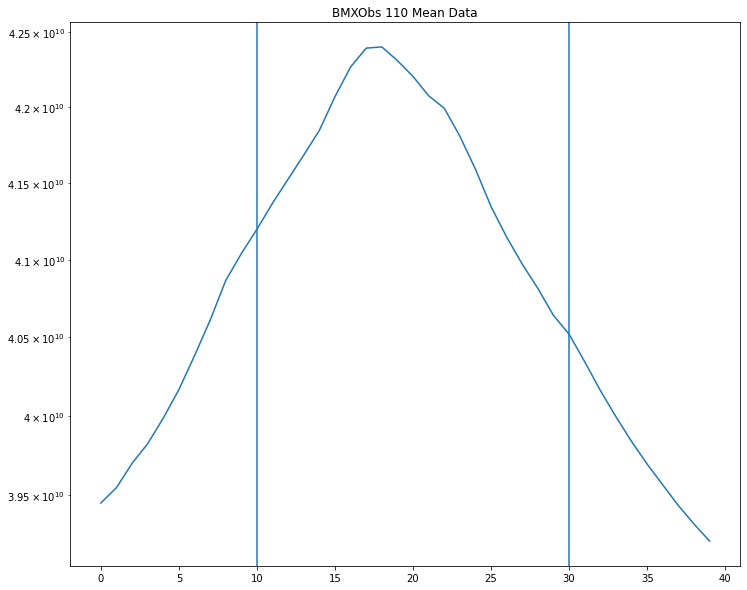

In [6]:
plt.figure(figsize=(12,10))
plt.yscale('log')
plt.plot(BMX[110].mean(axis=0)[1750:1790])
plt.axvline(10)
plt.axvline(30)
#plt.xlim(1750,1790)
plt.title('BMXObs 110 Mean Data')
plt.show()

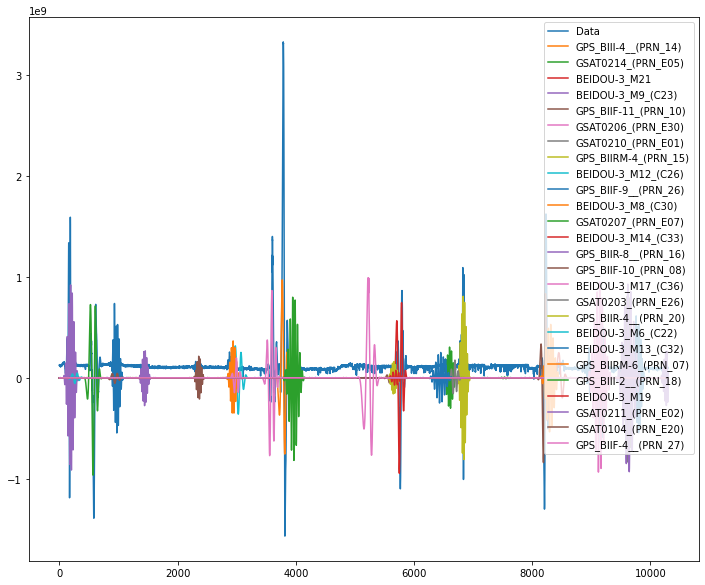

In [5]:
cut = [0,len(D[11])]
channel = 23

plt.figure(figsize=(12,10))
plt.plot(D[channel][cut[0]:cut[1]].real,label='Data')

tracks = {}
sats = {}
for n,s in zip(D.sat_id,D.sat):
    if "COS" not in n:
        #dx= np.exp(-np.cos(s['alt'])**2/(2*0.05**2))
        track = np.array([np.cos(s['alt'])*np.cos(s['az']),np.cos(s['alt'])*np.sin(s['az'])]).T
        dx = SingleFreqGeometry(freq=D.freq).point_source(channel,1,track).real
        if max(dx[cut[0]:cut[1]])>0.02:
            plt.plot(dx[cut[0]:cut[1]]*1e9,label=n)
            tracks[n] = track
            sats[n] = dx
        
plt.legend()
plt.show()
print(np.arange(cut[0],cut[1])[D[channel][cut[0]:cut[1]].real==max(D[channel][cut[0]:cut[1]].real)])

In [3]:
def getPhaseFit(Theory):
    detectors = [2,3,4,6,7,8]
    channelSet = [[12],[13,23],[14,24,34],
                  [56],[57,67],[58,68,78]]

    params = []
        
    for i,d in enumerate(detectors):
        ch = channelSet[i]
        names = ['D{}_pos_x'.format(d),
                 'D{}_pos_y'.format(d),
                 'D{}_phi'.format(d)
                ]

        params.append(Theory.fit(names, mode = 'phase', channels = ch, plot=False))
    
    return np.array(params)

In [4]:
def getBeamFit(Theory):
    detectors = [1,2,3,4,5,6,7,8]
    channelSet = [[11],[12,22],[13,23,33],[14,24,34,44],
                  [55],[56,66],[57,67,77],[58,68,78,88]]
    params = []

    for i,d in enumerate(detectors):
        ch = channelSet[i]
        names = ['D{}_beam_center_x'.format(d),
                'D{}_beam_center_y'.format(d),
                'D{}_beam_smooth_x'.format(d),
                'D{}_beam_smooth_y'.format(d)
                ]
        if Theory.geometry.ant_beam[d-1].airy:
            names += ['D{}_beam_sigma_x'.format(d),
                'D{}_beam_sigma_y'.format(d),]


        params.append(Theory.fit(names, mode = 'amp', channels = ch, plot=False))
    
    return np.array(params)

In [5]:
def getAmpFit(Theory, mode='amp'):
    detectors = [1,2,3,4,5,6,7,8]
    channelSet = [[11],[12,22],[13,23,33],[14,24,34,44],
                  [55],[56,66],[57,67,77],[58,68,78,88]]
    
    for i,d in enumerate(detectors):
        ch = channelSet[i]
        for j in range(len(Theory.data)):
            names = ["A{}_{}_{}".format(d,n,j) for n in Theory.satNames]
            #names += ["CH{}_offset_r".format(channel) for channel in ch]
            #for channel in ch:
                #if channel%11 != 0:
                    #names += ["CH{}_offset_i".format(channel)]
            names += ["A{}_{}_{}".format(d,n,j) for n in Theory.astroNames]
            if len(names)>0:
                Theory.fit(names, mode = mode, channels = ch, datNum=[j], plot=False, output=False)
            
    return

In [19]:
Data_ids = [["pas/210904_2300",
            "pas/210905_2300"],
            ["pas/210906_2300",
            "pas/210907_2300"],
            #["pas/210908_2300",
            #"pas/210909_2300"]
           ]
bins = (280,300) #1178 MHz
#bins = (1760,1780) #1575 MHz
DataSets = [[bmxobs.BMXSingleFreqObs(ids, freq_bins=bins) for ids in Data_id] for Data_id in Data_ids]

In [10]:
astroObj = { #'name':[RA in radians, DEC in radians]
    'Cygnus_A':[5.233686582997465, 0.7109409436737796]
}

In [11]:
#params1178 = [
    #{'A1_GPS_BIIR-8__(PRN_16)_0': -31896.401772967365, 'A1_GPS_BIIR-8__(PRN_16)_1': -124664.34166527528, 'A2_GPS_BIIR-8__(PRN_16)_0': -200492.99937518477, 'A2_GPS_BIIR-8__(PRN_16)_1': 2777.2770556270593, 'A3_GPS_BIIR-8__(PRN_16)_0': 31197.1853452285, 'A3_GPS_BIIR-8__(PRN_16)_1': -103048.58626038571, 'A4_GPS_BIIR-8__(PRN_16)_0': -985199.8601079399, 'A4_GPS_BIIR-8__(PRN_16)_1': 27025.2715334839, 'A5_GPS_BIIR-8__(PRN_16)_0': 137358.42953228278, 'A5_GPS_BIIR-8__(PRN_16)_1': 1301286.8244088206, 'A6_GPS_BIIR-8__(PRN_16)_0': 1066515.1944678307, 'A6_GPS_BIIR-8__(PRN_16)_1': -5813.759575912249, 'A7_GPS_BIIR-8__(PRN_16)_0': 1808397.104839363, 'A7_GPS_BIIR-8__(PRN_16)_1': 1167398.648276579, 'A8_GPS_BIIR-8__(PRN_16)_0': -3169.5666325365146, 'A8_GPS_BIIR-8__(PRN_16)_1': -184684.27959335127, 'GPS_BIIR-8__(PRN_16)_track_offset_x': 0.0, 'GPS_BIIR-8__(PRN_16)_track_offset_y': 0.0, 'GPS_BIIR-8__(PRN_16)_time_offset': 0, 'A1_GSAT0212_(PRN_E03)_0': 22189725.641581856, 'A1_GSAT0212_(PRN_E03)_1': 4647271.547899511, 'A2_GSAT0212_(PRN_E03)_0': 3477050772515.2114, 'A2_GSAT0212_(PRN_E03)_1': 2656686.520544912, 'A3_GSAT0212_(PRN_E03)_0': -14219878412796.982, 'A3_GSAT0212_(PRN_E03)_1': 6931780.6830908405, 'A4_GSAT0212_(PRN_E03)_0': -2500970596633507.5, 'A4_GSAT0212_(PRN_E03)_1': 23113576.97767496, 'A5_GSAT0212_(PRN_E03)_0': 5455725.40320662, 'A5_GSAT0212_(PRN_E03)_1': 3795945.7761696763, 'A6_GSAT0212_(PRN_E03)_0': 4960198.725026493, 'A6_GSAT0212_(PRN_E03)_1': 3191150.7413497507, 'A7_GSAT0212_(PRN_E03)_0': 8616381.81038711, 'A7_GSAT0212_(PRN_E03)_1': 5912113.966558098, 'A8_GSAT0212_(PRN_E03)_0': 15297400.968024453, 'A8_GSAT0212_(PRN_E03)_1': 15043829.530371334, 'GSAT0212_(PRN_E03)_track_offset_x': 0.0, 'GSAT0212_(PRN_E03)_track_offset_y': 0.0, 'GSAT0212_(PRN_E03)_time_offset': 0, 'A1_GSAT0205_(PRN_E24)_0': -494483.20851546276, 'A1_GSAT0205_(PRN_E24)_1': 1218881.6625347217, 'A2_GSAT0205_(PRN_E24)_0': -1615412.9742002496, 'A2_GSAT0205_(PRN_E24)_1': -69591.61923974135, 'A3_GSAT0205_(PRN_E24)_0': 20933.265743031472, 'A3_GSAT0205_(PRN_E24)_1': -211127.65797267837, 'A4_GSAT0205_(PRN_E24)_0': -5856835.708547618, 'A4_GSAT0205_(PRN_E24)_1': 1206643.5456594815, 'A5_GSAT0205_(PRN_E24)_0': 51546.85099956047, 'A5_GSAT0205_(PRN_E24)_1': 468643.06202547887, 'A6_GSAT0205_(PRN_E24)_0': -17112.94907664945, 'A6_GSAT0205_(PRN_E24)_1': -1426993.5092727353, 'A7_GSAT0205_(PRN_E24)_0': -119880.86521481755, 'A7_GSAT0205_(PRN_E24)_1': 3263613.5639450336, 'A8_GSAT0205_(PRN_E24)_0': 989948.8726973848, 'A8_GSAT0205_(PRN_E24)_1': 6867821.408992297, 'GSAT0205_(PRN_E24)_track_offset_x': 0.0, 'GSAT0205_(PRN_E24)_track_offset_y': 0.0, 'GSAT0205_(PRN_E24)_time_offset': 0, 'A1_GPS_BIIRM-6_(PRN_07)_0': 2576120.291015752, 'A1_GPS_BIIRM-6_(PRN_07)_1': 3548236.4403462503, 'A2_GPS_BIIRM-6_(PRN_07)_0': 4506224.27235558, 'A2_GPS_BIIRM-6_(PRN_07)_1': 3795555.19761619, 'A3_GPS_BIIRM-6_(PRN_07)_0': 6272335.061781259, 'A3_GPS_BIIRM-6_(PRN_07)_1': 5838950.451416291, 'A4_GPS_BIIRM-6_(PRN_07)_0': 3098336.6497928966, 'A4_GPS_BIIRM-6_(PRN_07)_1': -961663.0805832614, 'A5_GPS_BIIRM-6_(PRN_07)_0': -1477.8438037169396, 'A5_GPS_BIIRM-6_(PRN_07)_1': 255949.57556044115, 'A6_GPS_BIIRM-6_(PRN_07)_0': -2547107.9978921814, 'A6_GPS_BIIRM-6_(PRN_07)_1': -3361.9541383254277, 'A7_GPS_BIIRM-6_(PRN_07)_0': -437560.8693453897, 'A7_GPS_BIIRM-6_(PRN_07)_1': -19919.268888469822, 'A8_GPS_BIIRM-6_(PRN_07)_0': -947.3143957427455, 'A8_GPS_BIIRM-6_(PRN_07)_1': 710214.7606181224, 'GPS_BIIRM-6_(PRN_07)_track_offset_x': 0.0, 'GPS_BIIRM-6_(PRN_07)_track_offset_y': 0.0, 'GPS_BIIRM-6_(PRN_07)_time_offset': 0, 'A1_GSAT0202_(PRN_E14)_0': -2383527.8067835667, 'A1_GSAT0202_(PRN_E14)_1': -31320638.146935057, 'A2_GSAT0202_(PRN_E14)_0': 551211.7702470762, 'A2_GSAT0202_(PRN_E14)_1': 29564248.961123355, 'A3_GSAT0202_(PRN_E14)_0': 245180.66958366177, 'A3_GSAT0202_(PRN_E14)_1': 36131210.01774544, 'A4_GSAT0202_(PRN_E14)_0': -247.3581844113586, 'A4_GSAT0202_(PRN_E14)_1': -37357390.78514338, 'A5_GSAT0202_(PRN_E14)_0': 447.4599925151388, 'A5_GSAT0202_(PRN_E14)_1': -25101760.86862091, 'A6_GSAT0202_(PRN_E14)_0': 193359.28235784388, 'A6_GSAT0202_(PRN_E14)_1': 27535584.33304123, 'A7_GSAT0202_(PRN_E14)_0': 1143359.3279285799, 'A7_GSAT0202_(PRN_E14)_1': 30495802.490586426, 'A8_GSAT0202_(PRN_E14)_0': -3305630.627324822, 'A8_GSAT0202_(PRN_E14)_1': -21302707.409800738, 'GSAT0202_(PRN_E14)_track_offset_x': 0.0, 'GSAT0202_(PRN_E14)_track_offset_y': 0.0, 'GSAT0202_(PRN_E14)_time_offset': 0, 'A1_GPS_BIIRM-4_(PRN_15)_0': -257236.97163260882, 'A1_GPS_BIIRM-4_(PRN_15)_1': 57360.050391254445, 'A2_GPS_BIIRM-4_(PRN_15)_0': 130641.33310690276, 'A2_GPS_BIIRM-4_(PRN_15)_1': 299539.5345903275, 'A3_GPS_BIIRM-4_(PRN_15)_0': 24288.65651730475, 'A3_GPS_BIIRM-4_(PRN_15)_1': 162712.8025944049, 'A4_GPS_BIIRM-4_(PRN_15)_0': 1298984.1520251366, 'A4_GPS_BIIRM-4_(PRN_15)_1': 718834.835628115, 'A5_GPS_BIIRM-4_(PRN_15)_0': 224781.24336690435, 'A5_GPS_BIIRM-4_(PRN_15)_1': 2230616.0950597576, 'A6_GPS_BIIRM-4_(PRN_15)_0': 1240902.3002345108, 'A6_GPS_BIIRM-4_(PRN_15)_1': 1550576.3474878906, 'A7_GPS_BIIRM-4_(PRN_15)_0': 1636322.0272981266, 'A7_GPS_BIIRM-4_(PRN_15)_1': -442914.1940090615, 'A8_GPS_BIIRM-4_(PRN_15)_0': 27766.249958169883, 'A8_GPS_BIIRM-4_(PRN_15)_1': 258182.42733133258, 'GPS_BIIRM-4_(PRN_15)_track_offset_x': 0.0, 'GPS_BIIRM-4_(PRN_15)_track_offset_y': 0.0, 'GPS_BIIRM-4_(PRN_15)_time_offset': 0, 'A1_BEIDOU-3_M9_(C23)_0': 29124388.76140927, 'A1_BEIDOU-3_M9_(C23)_1': -180684.55008271424, 'A2_BEIDOU-3_M9_(C23)_0': 27927873.345074695, 'A2_BEIDOU-3_M9_(C23)_1': -841454.4749502542, 'A3_BEIDOU-3_M9_(C23)_0': 29371672.631158028, 'A3_BEIDOU-3_M9_(C23)_1': 394713.1294476269, 'A4_BEIDOU-3_M9_(C23)_0': 8898650.6873464, 'A4_BEIDOU-3_M9_(C23)_1': 42776.32127052704, 'A5_BEIDOU-3_M9_(C23)_0': 24880266.14561324, 'A5_BEIDOU-3_M9_(C23)_1': -166.74623938964447, 'A6_BEIDOU-3_M9_(C23)_0': 23637677.827938415, 'A6_BEIDOU-3_M9_(C23)_1': 57355.1765388211, 'A7_BEIDOU-3_M9_(C23)_0': 26739901.621387996, 'A7_BEIDOU-3_M9_(C23)_1': 1044470.3104767057, 'A8_BEIDOU-3_M9_(C23)_0': 9018036.924719281, 'A8_BEIDOU-3_M9_(C23)_1': 4327780.839482682, 'BEIDOU-3_M9_(C23)_track_offset_x': 0.0, 'BEIDOU-3_M9_(C23)_track_offset_y': 0.0, 'BEIDOU-3_M9_(C23)_time_offset': 0, 'A1_GSAT0101_(PRN_E11)_0': 5462576.10275619, 'A1_GSAT0101_(PRN_E11)_1': 4540823.139197065, 'A2_GSAT0101_(PRN_E11)_0': 4708524281481.239, 'A2_GSAT0101_(PRN_E11)_1': -6079230.846471119, 'A3_GSAT0101_(PRN_E11)_0': 1791846348562.9553, 'A3_GSAT0101_(PRN_E11)_1': 11710321.710790798, 'A4_GSAT0101_(PRN_E11)_0': 4.3740001549512936e+16, 'A4_GSAT0101_(PRN_E11)_1': 16776512.27800133, 'A5_GSAT0101_(PRN_E11)_0': 9172.394260619123, 'A5_GSAT0101_(PRN_E11)_1': -44324.13838436307, 'A6_GSAT0101_(PRN_E11)_0': -2315.23182231674, 'A6_GSAT0101_(PRN_E11)_1': -905.2030161390192, 'A7_GSAT0101_(PRN_E11)_0': -8376.16624347639, 'A7_GSAT0101_(PRN_E11)_1': -109604.53175444239, 'A8_GSAT0101_(PRN_E11)_0': -8613708.71153827, 'A8_GSAT0101_(PRN_E11)_1': -9265625.707572555, 'GSAT0101_(PRN_E11)_track_offset_x': 0.0, 'GSAT0101_(PRN_E11)_track_offset_y': 0.0, 'GSAT0101_(PRN_E11)_time_offset': 0, 'A1_GSAT0206_(PRN_E30)_0': 18041554.00262744, 'A1_GSAT0206_(PRN_E30)_1': 77940.88844014826, 'A2_GSAT0206_(PRN_E30)_0': 17431019.473077204, 'A2_GSAT0206_(PRN_E30)_1': 92418.60140255973, 'A3_GSAT0206_(PRN_E30)_0': 23835471.544845592, 'A3_GSAT0206_(PRN_E30)_1': 57554.066158511734, 'A4_GSAT0206_(PRN_E30)_0': 28368029.20088002, 'A4_GSAT0206_(PRN_E30)_1': -1503.8113533023666, 'A5_GSAT0206_(PRN_E30)_0': 14534760.801667651, 'A5_GSAT0206_(PRN_E30)_1': -7125.322495659434, 'A6_GSAT0206_(PRN_E30)_0': 16492180.079850147, 'A6_GSAT0206_(PRN_E30)_1': 942053.9952406435, 'A7_GSAT0206_(PRN_E30)_0': 20945015.30906845, 'A7_GSAT0206_(PRN_E30)_1': 1081473.4330212595, 'A8_GSAT0206_(PRN_E30)_0': 17639024.999527864, 'A8_GSAT0206_(PRN_E30)_1': 1355784.3236985796, 'GSAT0206_(PRN_E30)_track_offset_x': 0.0, 'GSAT0206_(PRN_E30)_track_offset_y': 0.0, 'GSAT0206_(PRN_E30)_time_offset': 0, 'A1_BEIDOU-3_M14_(C33)_0': 77992.65388465337, 'A1_BEIDOU-3_M14_(C33)_1': 2403031.2754954686, 'A2_BEIDOU-3_M14_(C33)_0': 168115.45418194734, 'A2_BEIDOU-3_M14_(C33)_1': 167620.47547888823, 'A3_BEIDOU-3_M14_(C33)_0': 175828.82481152646, 'A3_BEIDOU-3_M14_(C33)_1': -114041.48627083906, 'A4_BEIDOU-3_M14_(C33)_0': -167880.0809218287, 'A4_BEIDOU-3_M14_(C33)_1': 660051.6201524509, 'A5_BEIDOU-3_M14_(C33)_0': 4251556.090439499, 'A5_BEIDOU-3_M14_(C33)_1': 5041840.121974459, 'A6_BEIDOU-3_M14_(C33)_0': 4632975.812822929, 'A6_BEIDOU-3_M14_(C33)_1': 4957087.777969249, 'A7_BEIDOU-3_M14_(C33)_0': 6296889.711510094, 'A7_BEIDOU-3_M14_(C33)_1': 7211028.692847793, 'A8_BEIDOU-3_M14_(C33)_0': 3779046.1825344637, 'A8_BEIDOU-3_M14_(C33)_1': 42632.105049572245, 'BEIDOU-3_M14_(C33)_track_offset_x': 0.0, 'BEIDOU-3_M14_(C33)_track_offset_y': 0.0, 'BEIDOU-3_M14_(C33)_time_offset': 0, 'A1_BEIDOU-3_M17_(C36)_0': 5540749.185357011, 'A1_BEIDOU-3_M17_(C36)_1': 4168715.4527465994, 'A2_BEIDOU-3_M17_(C36)_0': 4299941.985766352, 'A2_BEIDOU-3_M17_(C36)_1': 70395112583107.97, 'A3_BEIDOU-3_M17_(C36)_0': 8072743.516822706, 'A3_BEIDOU-3_M17_(C36)_1': 129516304959286.06, 'A4_BEIDOU-3_M17_(C36)_0': 15213458.116406815, 'A4_BEIDOU-3_M17_(C36)_1': -24006141656193.62, 'A5_BEIDOU-3_M17_(C36)_0': 4041317.67606377, 'A5_BEIDOU-3_M17_(C36)_1': 3011051.901130076, 'A6_BEIDOU-3_M17_(C36)_0': 3037295.775400319, 'A6_BEIDOU-3_M17_(C36)_1': 2632400.4913488394, 'A7_BEIDOU-3_M17_(C36)_0': 5079385.140655097, 'A7_BEIDOU-3_M17_(C36)_1': 3735345.6341633387, 'A8_BEIDOU-3_M17_(C36)_0': 4092139.492342313, 'A8_BEIDOU-3_M17_(C36)_1': 6354376973620.017, 'BEIDOU-3_M17_(C36)_track_offset_x': 0.0, 'BEIDOU-3_M17_(C36)_track_offset_y': 0.0, 'BEIDOU-3_M17_(C36)_time_offset': 0, 'A1_GPS_BIIF-9__(PRN_26)_0': 18267211.548381258, 'A1_GPS_BIIF-9__(PRN_26)_1': 18112564.279891152, 'A2_GPS_BIIF-9__(PRN_26)_0': 19683886.14680761, 'A2_GPS_BIIF-9__(PRN_26)_1': 19375563.794636663, 'A3_GPS_BIIF-9__(PRN_26)_0': 14841443.09378015, 'A3_GPS_BIIF-9__(PRN_26)_1': 14699240.503565324, 'A4_GPS_BIIF-9__(PRN_26)_0': 1196874.929298314, 'A4_GPS_BIIF-9__(PRN_26)_1': 739780.2589148465, 'A5_GPS_BIIF-9__(PRN_26)_0': 13195351.490684023, 'A5_GPS_BIIF-9__(PRN_26)_1': 13091844.563305672, 'A6_GPS_BIIF-9__(PRN_26)_0': 15975721.601065896, 'A6_GPS_BIIF-9__(PRN_26)_1': 15796464.509130664, 'A7_GPS_BIIF-9__(PRN_26)_0': 14075505.59858979, 'A7_GPS_BIIF-9__(PRN_26)_1': 13847840.122287637, 'A8_GPS_BIIF-9__(PRN_26)_0': 3627628.8024903834, 'A8_GPS_BIIF-9__(PRN_26)_1': 3529532.8756994805, 'GPS_BIIF-9__(PRN_26)_track_offset_x': 0.0, 'GPS_BIIF-9__(PRN_26)_track_offset_y': 0.0, 'GPS_BIIF-9__(PRN_26)_time_offset': 0, 'A1_GPS_BIIF-4__(PRN_27)_0': -30648.48209402329, 'A1_GPS_BIIF-4__(PRN_27)_1': 992406.5350767293, 'A2_GPS_BIIF-4__(PRN_27)_0': 22286.359774676966, 'A2_GPS_BIIF-4__(PRN_27)_1': 2480129.943325714, 'A3_GPS_BIIF-4__(PRN_27)_0': -2352.6124611510204, 'A3_GPS_BIIF-4__(PRN_27)_1': -820972.6328283435, 'A4_GPS_BIIF-4__(PRN_27)_0': 170078.60581811238, 'A4_GPS_BIIF-4__(PRN_27)_1': 30819.538507894875, 'A5_GPS_BIIF-4__(PRN_27)_0': 4.022460589552435, 'A5_GPS_BIIF-4__(PRN_27)_1': -10.262347833571017, 'A6_GPS_BIIF-4__(PRN_27)_0': -1779924.759446196, 'A6_GPS_BIIF-4__(PRN_27)_1': -80629.70407961507, 'A7_GPS_BIIF-4__(PRN_27)_0': 222193.9290428102, 'A7_GPS_BIIF-4__(PRN_27)_1': 21736.471646208694, 'A8_GPS_BIIF-4__(PRN_27)_0': -37044.2229464825, 'A8_GPS_BIIF-4__(PRN_27)_1': -2602721.3371873144, 'GPS_BIIF-4__(PRN_27)_track_offset_x': 0.0, 'GPS_BIIF-4__(PRN_27)_track_offset_y': 0.0, 'GPS_BIIF-4__(PRN_27)_time_offset': 0, 'A1_BEIDOU-3_M20_0': -2009541.6617184628, 'A1_BEIDOU-3_M20_1': -16574517.32485519, 'A2_BEIDOU-3_M20_0': -2072683.7919544983, 'A2_BEIDOU-3_M20_1': -15394320.222836573, 'A3_BEIDOU-3_M20_0': -1161.991291114311, 'A3_BEIDOU-3_M20_1': -13579764.25711255, 'A4_BEIDOU-3_M20_0': 220040.9146184246, 'A4_BEIDOU-3_M20_1': 5530776.195059211, 'A5_BEIDOU-3_M20_0': 489090.12431350345, 'A5_BEIDOU-3_M20_1': 13432838.298256166, 'A6_BEIDOU-3_M20_0': -2398530.866248852, 'A6_BEIDOU-3_M20_1': -11959009.028671987, 'A7_BEIDOU-3_M20_0': 60539.227912160975, 'A7_BEIDOU-3_M20_1': -11650326.670879666, 'A8_BEIDOU-3_M20_0': 11135.119898907797, 'A8_BEIDOU-3_M20_1': -7616921.718327889, 'BEIDOU-3_M20_track_offset_x': 0.0, 'BEIDOU-3_M20_track_offset_y': 0.0, 'BEIDOU-3_M20_time_offset': 0, 'A1_BEIDOU-3_M3_(C27)_0': 19766759.975418184, 'A1_BEIDOU-3_M3_(C27)_1': 16180882.881494747, 'A2_BEIDOU-3_M3_(C27)_0': 173747622703.64682, 'A2_BEIDOU-3_M3_(C27)_1': 17708837.175772075, 'A3_BEIDOU-3_M3_(C27)_0': -69541556246823.25, 'A3_BEIDOU-3_M3_(C27)_1': 14614273.331999658, 'A4_BEIDOU-3_M3_(C27)_0': 6510488724828992.0, 'A4_BEIDOU-3_M3_(C27)_1': -1643261.8438175549, 'A5_BEIDOU-3_M3_(C27)_0': 14813242.38740307, 'A5_BEIDOU-3_M3_(C27)_1': 13188337.394444201, 'A6_BEIDOU-3_M3_(C27)_0': 16215165.72099592, 'A6_BEIDOU-3_M3_(C27)_1': 15061136.59383066, 'A7_BEIDOU-3_M3_(C27)_0': 15611758.547226422, 'A7_BEIDOU-3_M3_(C27)_1': 13984064.343418667, 'A8_BEIDOU-3_M3_(C27)_0': 803731.3775013717, 'A8_BEIDOU-3_M3_(C27)_1': 519174.2568600692, 'BEIDOU-3_M3_(C27)_track_offset_x': 0.0, 'BEIDOU-3_M3_(C27)_track_offset_y': 0.0, 'BEIDOU-3_M3_(C27)_time_offset': 0, 'A1_BEIDOU-3_M10_(C24)_0': 30179333.49600659, 'A1_BEIDOU-3_M10_(C24)_1': 6687069.766468654, 'A2_BEIDOU-3_M10_(C24)_0': 8011270681638.304, 'A2_BEIDOU-3_M10_(C24)_1': 3589071.239524392, 'A3_BEIDOU-3_M10_(C24)_0': 17167190820819.152, 'A3_BEIDOU-3_M10_(C24)_1': 6827773.18506257, 'A4_BEIDOU-3_M10_(C24)_0': -5.14420477341004e+16, 'A4_BEIDOU-3_M10_(C24)_1': 26276911.47492161, 'A5_BEIDOU-3_M10_(C24)_0': 11760008.277235225, 'A5_BEIDOU-3_M10_(C24)_1': 7669499.10068358, 'A6_BEIDOU-3_M10_(C24)_0': 7460698.094020618, 'A6_BEIDOU-3_M10_(C24)_1': 4405657.128486525, 'A7_BEIDOU-3_M10_(C24)_0': 10986719.348298136, 'A7_BEIDOU-3_M10_(C24)_1': 7336394.980968545, 'A8_BEIDOU-3_M10_(C24)_0': 17989740.965813924, 'A8_BEIDOU-3_M10_(C24)_1': 17989268.225818202, 'BEIDOU-3_M10_(C24)_track_offset_x': 0.0, 'BEIDOU-3_M10_(C24)_track_offset_y': 0.0, 'BEIDOU-3_M10_(C24)_time_offset': 0, 'A1_BEIDOU-3_M11_(C25)_0': 35118339.6894941, 'A1_BEIDOU-3_M11_(C25)_1': 5099432.552313857, 'A2_BEIDOU-3_M11_(C25)_0': -6425810218790.399, 'A2_BEIDOU-3_M11_(C25)_1': 5712032.913295797, 'A3_BEIDOU-3_M11_(C25)_0': -4893033884541.005, 'A3_BEIDOU-3_M11_(C25)_1': 4391308.630224403, 'A4_BEIDOU-3_M11_(C25)_0': 7.4202510914812e+16, 'A4_BEIDOU-3_M11_(C25)_1': 5877.459582986346, 'A5_BEIDOU-3_M11_(C25)_0': 9100927.073877674, 'A5_BEIDOU-3_M11_(C25)_1': 4793020.468087905, 'A6_BEIDOU-3_M11_(C25)_0': 11118727.39829711, 'A6_BEIDOU-3_M11_(C25)_1': 6617683.313936573, 'A7_BEIDOU-3_M11_(C25)_0': 9101704.254643654, 'A7_BEIDOU-3_M11_(C25)_1': 5299102.926784603, 'A8_BEIDOU-3_M11_(C25)_0': 2898220.602756965, 'A8_BEIDOU-3_M11_(C25)_1': 1888260.823982927, 'BEIDOU-3_M11_(C25)_track_offset_x': 0.0, 'BEIDOU-3_M11_(C25)_track_offset_y': 0.0, 'BEIDOU-3_M11_(C25)_time_offset': 0, 'A1_GSAT0103_(PRN_E19)_0': 2581.9878989750027, 'A1_GSAT0103_(PRN_E19)_1': -41367.190939501794, 'A2_GSAT0103_(PRN_E19)_0': 54782.01131499832, 'A2_GSAT0103_(PRN_E19)_1': 76380.17991139958, 'A3_GSAT0103_(PRN_E19)_0': 3388.4544972891235, 'A3_GSAT0103_(PRN_E19)_1': 1540016.1431369074, 'A4_GSAT0103_(PRN_E19)_0': 200799.89503790904, 'A4_GSAT0103_(PRN_E19)_1': 446136.80009510217, 'A5_GSAT0103_(PRN_E19)_0': -3765.0025742839007, 'A5_GSAT0103_(PRN_E19)_1': -868298.3236947486, 'A6_GSAT0103_(PRN_E19)_0': 343887.1448492248, 'A6_GSAT0103_(PRN_E19)_1': 1054208.9574651897, 'A7_GSAT0103_(PRN_E19)_0': -1816843.9369620609, 'A7_GSAT0103_(PRN_E19)_1': -2264300.388864393, 'A8_GSAT0103_(PRN_E19)_0': 55818.987241881296, 'A8_GSAT0103_(PRN_E19)_1': 100514.7390121758, 'GSAT0103_(PRN_E19)_track_offset_x': 0.0, 'GSAT0103_(PRN_E19)_track_offset_y': 0.0, 'GSAT0103_(PRN_E19)_time_offset': 0, 'A1_GPS_BIIF-11_(PRN_10)_0': 24871205.83282315, 'A1_GPS_BIIF-11_(PRN_10)_1': 24157090.721232627, 'A2_GPS_BIIF-11_(PRN_10)_0': 24068511.11505022, 'A2_GPS_BIIF-11_(PRN_10)_1': 23034932.840084855, 'A3_GPS_BIIF-11_(PRN_10)_0': 31353738.832485504, 'A3_GPS_BIIF-11_(PRN_10)_1': 29582359.969136957, 'A4_GPS_BIIF-11_(PRN_10)_0': 34817456.65529602, 'A4_GPS_BIIF-11_(PRN_10)_1': 32674159.092135027, 'A5_GPS_BIIF-11_(PRN_10)_0': 20962168.271241818, 'A5_GPS_BIIF-11_(PRN_10)_1': 19841055.659792, 'A6_GPS_BIIF-11_(PRN_10)_0': 22843083.16571538, 'A6_GPS_BIIF-11_(PRN_10)_1': 21877238.807336394, 'A7_GPS_BIIF-11_(PRN_10)_0': 27840973.280413397, 'A7_GPS_BIIF-11_(PRN_10)_1': 26433023.91953073, 'A8_GPS_BIIF-11_(PRN_10)_0': 21222531.572851904, 'A8_GPS_BIIF-11_(PRN_10)_1': 20783670.72064274, 'GPS_BIIF-11_(PRN_10)_track_offset_x': 0.0, 'GPS_BIIF-11_(PRN_10)_track_offset_y': 0.0, 'GPS_BIIF-11_(PRN_10)_time_offset': 0, 'A1_BEIDOU-3_M15_(C34)_0': 1538317.8314697936, 'A1_BEIDOU-3_M15_(C34)_1': 7296998.702416014, 'A2_BEIDOU-3_M15_(C34)_0': -1853909.2689729088, 'A2_BEIDOU-3_M15_(C34)_1': -6397875.662845204, 'A3_BEIDOU-3_M15_(C34)_0': 2058.7694427381757, 'A3_BEIDOU-3_M15_(C34)_1': 10889501.23925476, 'A4_BEIDOU-3_M15_(C34)_0': 808789.0403382573, 'A4_BEIDOU-3_M15_(C34)_1': -20161981.739549845, 'A5_BEIDOU-3_M15_(C34)_0': 2235.8300295843483, 'A5_BEIDOU-3_M15_(C34)_1': -2179870.2057665717, 'A6_BEIDOU-3_M15_(C34)_0': -1195278.4016025055, 'A6_BEIDOU-3_M15_(C34)_1': -4884445.228703351, 'A7_BEIDOU-3_M15_(C34)_0': 945363.7781468725, 'A7_BEIDOU-3_M15_(C34)_1': 5404917.411192612, 'A8_BEIDOU-3_M15_(C34)_0': -3227.524252681693, 'A8_BEIDOU-3_M15_(C34)_1': 14015274.804511175, 'BEIDOU-3_M15_(C34)_track_offset_x': 0.0, 'BEIDOU-3_M15_(C34)_track_offset_y': 0.0, 'BEIDOU-3_M15_(C34)_time_offset': 0, 'A1_BEIDOU-3_M21_0': 22390866.06805396, 'A1_BEIDOU-3_M21_1': 25198909.807532296, 'A2_BEIDOU-3_M21_0': 21043234.08186252, 'A2_BEIDOU-3_M21_1': 48155928742452.27, 'A3_BEIDOU-3_M21_0': 26544151.262536097, 'A3_BEIDOU-3_M21_1': 16114809166864.615, 'A4_BEIDOU-3_M21_0': 27151366.32824899, 'A4_BEIDOU-3_M21_1': -160521518104844.28, 'A5_BEIDOU-3_M21_0': 18244035.6055877, 'A5_BEIDOU-3_M21_1': 18493365.497531444, 'A6_BEIDOU-3_M21_0': 19506852.160782933, 'A6_BEIDOU-3_M21_1': 19643436.20433766, 'A7_BEIDOU-3_M21_0': 23070930.081204787, 'A7_BEIDOU-3_M21_1': 23192469.956393544, 'A8_BEIDOU-3_M21_0': 16633274.230187926, 'A8_BEIDOU-3_M21_1': 14082283520216.48, 'BEIDOU-3_M21_track_offset_x': 0.0, 'BEIDOU-3_M21_track_offset_y': 0.0, 'BEIDOU-3_M21_time_offset': 0, 'A1_GSAT0207_(PRN_E07)_0': 7597160.169036166, 'A1_GSAT0207_(PRN_E07)_1': 12427664.671551183, 'A2_GSAT0207_(PRN_E07)_0': 8265370.009072024, 'A2_GSAT0207_(PRN_E07)_1': 11270601.40349068, 'A3_GSAT0207_(PRN_E07)_0': 5239706.2181955585, 'A3_GSAT0207_(PRN_E07)_1': 10578558.375640506, 'A4_GSAT0207_(PRN_E07)_0': 222963.36481255633, 'A4_GSAT0207_(PRN_E07)_1': 15751047.560878597, 'A5_GSAT0207_(PRN_E07)_0': 5741925.865761978, 'A5_GSAT0207_(PRN_E07)_1': 10306866.528742475, 'A6_GSAT0207_(PRN_E07)_0': 8408786.746280141, 'A6_GSAT0207_(PRN_E07)_1': 8775072.167219423, 'A7_GSAT0207_(PRN_E07)_0': 7521814.9943381315, 'A7_GSAT0207_(PRN_E07)_1': 9512952.961318683, 'A8_GSAT0207_(PRN_E07)_0': 6848109.590733618, 'A8_GSAT0207_(PRN_E07)_1': 6386907.882568575, 'GSAT0207_(PRN_E07)_track_offset_x': 0.0, 'GSAT0207_(PRN_E07)_track_offset_y': 0.0, 'GSAT0207_(PRN_E07)_time_offset': 0, 'A1_GSAT0211_(PRN_E02)_0': 5779740.853544668, 'A1_GSAT0211_(PRN_E02)_1': 6732109.259635742, 'A2_GSAT0211_(PRN_E02)_0': -32463.06843728712, 'A2_GSAT0211_(PRN_E02)_1': 36176919173161.65, 'A3_GSAT0211_(PRN_E02)_0': 852293.3866750969, 'A3_GSAT0211_(PRN_E02)_1': 58084682985047.84, 'A4_GSAT0211_(PRN_E02)_0': -1988574.9137592164, 'A4_GSAT0211_(PRN_E02)_1': 7669457793949.857, 'A5_GSAT0211_(PRN_E02)_0': 15.799532782299725, 'A5_GSAT0211_(PRN_E02)_1': 15.798312110829473, 'A6_GSAT0211_(PRN_E02)_0': -2.4888013042634753, 'A6_GSAT0211_(PRN_E02)_1': -2.4887491483182136, 'A7_GSAT0211_(PRN_E02)_0': 25350.59605225309, 'A7_GSAT0211_(PRN_E02)_1': -2.0852785838192993, 'A8_GSAT0211_(PRN_E02)_0': -594883.6833691291, 'A8_GSAT0211_(PRN_E02)_1': 8511253770947.293, 'GSAT0211_(PRN_E02)_track_offset_x': 0.0, 'GSAT0211_(PRN_E02)_track_offset_y': 0.0, 'GSAT0211_(PRN_E02)_time_offset': 0, 'A1_BEIDOU-3_M8_(C30)_0': 7936287.171721705, 'A1_BEIDOU-3_M8_(C30)_1': 4767275.640325234, 'A2_BEIDOU-3_M8_(C30)_0': 9673475.631466491, 'A2_BEIDOU-3_M8_(C30)_1': 4770739.850142094, 'A3_BEIDOU-3_M8_(C30)_0': 6495251.680602316, 'A3_BEIDOU-3_M8_(C30)_1': 502519.2862182326, 'A4_BEIDOU-3_M8_(C30)_0': 8874.019567617594, 'A4_BEIDOU-3_M8_(C30)_1': 6883617.965039755, 'A5_BEIDOU-3_M8_(C30)_0': 5727180.019984781, 'A5_BEIDOU-3_M8_(C30)_1': 84887.4417121352, 'A6_BEIDOU-3_M8_(C30)_0': 8490466.881519465, 'A6_BEIDOU-3_M8_(C30)_1': 1320090.7512575265, 'A7_BEIDOU-3_M8_(C30)_0': 7733629.711875936, 'A7_BEIDOU-3_M8_(C30)_1': 648351.0928790271, 'A8_BEIDOU-3_M8_(C30)_0': 6770176.487855434, 'A8_BEIDOU-3_M8_(C30)_1': 7356478.072797118, 'BEIDOU-3_M8_(C30)_track_offset_x': 0.0, 'BEIDOU-3_M8_(C30)_track_offset_y': 0.0, 'BEIDOU-3_M8_(C30)_time_offset': 0, 'A1_GSAT0214_(PRN_E05)_0': 22343981.16801877, 'A1_GSAT0214_(PRN_E05)_1': 24574873.578845933, 'A2_GSAT0214_(PRN_E05)_0': 21042447.305039182, 'A2_GSAT0214_(PRN_E05)_1': -23888305467303.81, 'A3_GSAT0214_(PRN_E05)_0': 26732113.824297972, 'A3_GSAT0214_(PRN_E05)_1': 17016121865755.848, 'A4_GSAT0214_(PRN_E05)_0': 25200072.817932043, 'A4_GSAT0214_(PRN_E05)_1': -118186877231136.89, 'A5_GSAT0214_(PRN_E05)_0': 18273404.006541763, 'A5_GSAT0214_(PRN_E05)_1': 18449344.192458175, 'A6_GSAT0214_(PRN_E05)_0': 20104388.30668685, 'A6_GSAT0214_(PRN_E05)_1': 20137932.07381084, 'A7_GSAT0214_(PRN_E05)_0': 23720316.48395025, 'A7_GSAT0214_(PRN_E05)_1': 23774554.940838996, 'A8_GSAT0214_(PRN_E05)_0': 16205369.363062372, 'A8_GSAT0214_(PRN_E05)_1': 8561001415701.168, 'GSAT0214_(PRN_E05)_track_offset_x': 0.0, 'GSAT0214_(PRN_E05)_track_offset_y': 0.0, 'GSAT0214_(PRN_E05)_time_offset': 0, 'A1_GPS_BIII-2__(PRN_18)_0': 277632.66103028285, 'A1_GPS_BIII-2__(PRN_18)_1': 2060747.2694545188, 'A2_GPS_BIII-2__(PRN_18)_0': -39567.14205759546, 'A2_GPS_BIII-2__(PRN_18)_1': 158897.7195402099, 'A3_GPS_BIII-2__(PRN_18)_0': -9434.552003988501, 'A3_GPS_BIII-2__(PRN_18)_1': 1075778.657079306, 'A4_GPS_BIII-2__(PRN_18)_0': -383416.3304503786, 'A4_GPS_BIII-2__(PRN_18)_1': -88914.13206472486, 'A5_GPS_BIII-2__(PRN_18)_0': 9.463068161597311, 'A5_GPS_BIII-2__(PRN_18)_1': 9.463466116697607, 'A6_GPS_BIII-2__(PRN_18)_0': 957332.8247311766, 'A6_GPS_BIII-2__(PRN_18)_1': 654065.05122813, 'A7_GPS_BIII-2__(PRN_18)_0': 355070.3908336117, 'A7_GPS_BIII-2__(PRN_18)_1': -860403.290417288, 'A8_GPS_BIII-2__(PRN_18)_0': 1503.0442890762101, 'A8_GPS_BIII-2__(PRN_18)_1': 232240.0032795386, 'GPS_BIII-2__(PRN_18)_track_offset_x': 0.0, 'GPS_BIII-2__(PRN_18)_track_offset_y': 0.0, 'GPS_BIII-2__(PRN_18)_time_offset': 0, 'A1_GPS_BIII-4__(PRN_14)_0': 40992972.7592407, 'A1_GPS_BIII-4__(PRN_14)_1': 39964126.42154571, 'A2_GPS_BIII-4__(PRN_14)_0': 40399992.87083684, 'A2_GPS_BIII-4__(PRN_14)_1': 39310563.87560973, 'A3_GPS_BIII-4__(PRN_14)_0': 47355183.26633, 'A3_GPS_BIII-4__(PRN_14)_1': 45317410.475445606, 'A4_GPS_BIII-4__(PRN_14)_0': 40330271.17954789, 'A4_GPS_BIII-4__(PRN_14)_1': 38681268.49739487, 'A5_GPS_BIII-4__(PRN_14)_0': 35926750.27829697, 'A5_GPS_BIII-4__(PRN_14)_1': 34506032.87761769, 'A6_GPS_BIII-4__(PRN_14)_0': 34971166.39568972, 'A6_GPS_BIII-4__(PRN_14)_1': 33833730.21508263, 'A7_GPS_BIII-4__(PRN_14)_0': 39973457.457408324, 'A7_GPS_BIII-4__(PRN_14)_1': 38562361.520278424, 'A8_GPS_BIII-4__(PRN_14)_0': 24566116.173752487, 'A8_GPS_BIII-4__(PRN_14)_1': 23445697.037065387, 'GPS_BIII-4__(PRN_14)_track_offset_x': 0.0, 'GPS_BIII-4__(PRN_14)_track_offset_y': 0.0, 'GPS_BIII-4__(PRN_14)_time_offset': 0, 'A1_BEIDOU-3_M23_(C45)_0': 4891455.50796329, 'A1_BEIDOU-3_M23_(C45)_1': 4790187.398711607, 'A2_BEIDOU-3_M23_(C45)_0': 2334616.5039377133, 'A2_BEIDOU-3_M23_(C45)_1': 5575816.658903607, 'A3_BEIDOU-3_M23_(C45)_0': 44879.50537798508, 'A3_BEIDOU-3_M23_(C45)_1': 5489283.472526915, 'A4_BEIDOU-3_M23_(C45)_0': -8703.104200982698, 'A4_BEIDOU-3_M23_(C45)_1': -402216.55903101503, 'A5_BEIDOU-3_M23_(C45)_0': -1515776.570601042, 'A5_BEIDOU-3_M23_(C45)_1': 307010.2306548979, 'A6_BEIDOU-3_M23_(C45)_0': -1144335.0196133505, 'A6_BEIDOU-3_M23_(C45)_1': -4229372.990597183, 'A7_BEIDOU-3_M23_(C45)_0': 189731.9114499363, 'A7_BEIDOU-3_M23_(C45)_1': -3019677.42958726, 'A8_BEIDOU-3_M23_(C45)_0': -605035.2864284972, 'A8_BEIDOU-3_M23_(C45)_1': -3754247.264297985, 'BEIDOU-3_M23_(C45)_track_offset_x': 0.0, 'BEIDOU-3_M23_(C45)_track_offset_y': 0.0, 'BEIDOU-3_M23_(C45)_time_offset': 0, 'A1_BEIDOU-3_M12_(C26)_0': 3082994.7980289836, 'A1_BEIDOU-3_M12_(C26)_1': 7181053.708422317, 'A2_BEIDOU-3_M12_(C26)_0': 775945.8545210008, 'A2_BEIDOU-3_M12_(C26)_1': 4398358.880888539, 'A3_BEIDOU-3_M12_(C26)_0': 3077568.2601808393, 'A3_BEIDOU-3_M12_(C26)_1': 9641122.958815021, 'A4_BEIDOU-3_M12_(C26)_0': -20151251.51550828, 'A4_BEIDOU-3_M12_(C26)_1': 25040498.543909613, 'A5_BEIDOU-3_M12_(C26)_0': 4060445.700302022, 'A5_BEIDOU-3_M12_(C26)_1': 5473785.046752858, 'A6_BEIDOU-3_M12_(C26)_0': 4201639.3005784275, 'A6_BEIDOU-3_M12_(C26)_1': 5113471.714207687, 'A7_BEIDOU-3_M12_(C26)_0': 6911072.74346555, 'A7_BEIDOU-3_M12_(C26)_1': 8069515.99092289, 'A8_BEIDOU-3_M12_(C26)_0': 15551567.285121178, 'A8_BEIDOU-3_M12_(C26)_1': 17201696.37649812, 'BEIDOU-3_M12_(C26)_track_offset_x': 0.0, 'BEIDOU-3_M12_(C26)_track_offset_y': 0.0, 'BEIDOU-3_M12_(C26)_time_offset': 0, 'A1_GSAT0210_(PRN_E01)_0': 20743670.604776498, 'A1_GSAT0210_(PRN_E01)_1': 21564133.705204632, 'A2_GSAT0210_(PRN_E01)_0': 21921971.272257265, 'A2_GSAT0210_(PRN_E01)_1': 21791905.657041013, 'A3_GSAT0210_(PRN_E01)_0': 19926836.23685319, 'A3_GSAT0210_(PRN_E01)_1': 19975514.612933896, 'A4_GSAT0210_(PRN_E01)_0': 4343254.676517626, 'A4_GSAT0210_(PRN_E01)_1': 4076210.616667035, 'A5_GSAT0210_(PRN_E01)_0': 19130845.19726473, 'A5_GSAT0210_(PRN_E01)_1': 19173813.606058262, 'A6_GSAT0210_(PRN_E01)_0': 19039988.67135768, 'A6_GSAT0210_(PRN_E01)_1': 18990626.78481854, 'A7_GSAT0210_(PRN_E01)_0': 18992318.757645626, 'A7_GSAT0210_(PRN_E01)_1': 18971532.641959116, 'A8_GSAT0210_(PRN_E01)_0': 5825225.747880061, 'A8_GSAT0210_(PRN_E01)_1': 5840478.76965657, 'GSAT0210_(PRN_E01)_track_offset_x': 0.0, 'GSAT0210_(PRN_E01)_track_offset_y': 0.0, 'GSAT0210_(PRN_E01)_time_offset': 0, 'A1_Cygnus_A_0': 43776.91309068017, 'A1_Cygnus_A_1': 78092.55796374414, 'A2_Cygnus_A_0': 43776.91309068017, 'A2_Cygnus_A_1': 78092.55796374414, 'A3_Cygnus_A_0': 43776.91309068017, 'A3_Cygnus_A_1': 78092.55796374414, 'A4_Cygnus_A_0': 43776.91309068017, 'A4_Cygnus_A_1': 78092.55796374414, 'A5_Cygnus_A_0': 43776.91309068017, 'A5_Cygnus_A_1': 78092.55796374414, 'A6_Cygnus_A_0': 43776.91309068017, 'A6_Cygnus_A_1': 78092.55796374414, 'A7_Cygnus_A_0': 43776.91309068017, 'A7_Cygnus_A_1': 78092.55796374414, 'A8_Cygnus_A_0': 43776.91309068017, 'A8_Cygnus_A_1': 78092.55796374414, 'freq': 1205.0, 'time_offset_all': 0, 'D1_pos_x': 0.0, 'D1_pos_y': 4.4248027, 'D1_phi': 0.0, 'D1_beam_center_x': 0.014074368976802549, 'D1_beam_center_y': -0.01829209543313745, 'D1_beam_sigma_x': 1.9798529888825644, 'D1_beam_sigma_y': 2.7173858414802368, 'D1_beam_smooth_x': 0.05172094231038457, 'D1_beam_smooth_y': 0.04698002212931284, 'D2_pos_x': 4.4093599701169826, 'D2_pos_y': -0.049674970266514316, 'D2_phi': -0.2423606756136261, 'D2_beam_center_x': 0.013651849332459958, 'D2_beam_center_y': -0.01925138183234807, 'D2_beam_sigma_x': 7.874425772458936, 'D2_beam_sigma_y': 13.497848573648454, 'D2_beam_smooth_x': 0.04596166825180247, 'D2_beam_smooth_y': 0.04388233814250241, 'D3_pos_x': 0.24803377281597347, 'D3_pos_y': -4.304977578272119, 'D3_phi': 2.3545359633910063, 'D3_beam_center_x': -0.001599007351449404, 'D3_beam_center_y': -0.010445208818360885, 'D3_beam_sigma_x': 3.643757136511408, 'D3_beam_sigma_y': 4.133951956697728, 'D3_beam_smooth_x': 0.044375818796036755, 'D3_beam_smooth_y': 0.05154254113222848, 'D4_pos_x': -4.092955334159885, 'D4_pos_y': 0.2486376225078711, 'D4_phi': -0.3768064113134565, 'D4_beam_center_x': -0.04506599072521995, 'D4_beam_center_y': 0.017579972401952335, 'D4_beam_sigma_x': 0.029626560047392784, 'D4_beam_sigma_y': 0.047645245625455725, 'D4_beam_smooth_x': 0.09035685675065518, 'D4_beam_smooth_y': 0.045813882912918366, 'D5_pos_x': 0.0, 'D5_pos_y': 4.0, 'D5_phi': 0.0, 'D5_beam_center_x': 0.004123007159934062, 'D5_beam_center_y': -0.017665679455424226, 'D5_beam_sigma_x': 0.04664882825626863, 'D5_beam_sigma_y': 0.031046275765901167, 'D5_beam_smooth_x': 21.7860986038692, 'D5_beam_smooth_y': 18.7817657738378, 'D6_pos_x': 4.251473589169464, 'D6_pos_y': -0.21049256747476958, 'D6_phi': 2.817590441291437, 'D6_beam_center_x': 0.0031569787047124286, 'D6_beam_center_y': -0.027058126992859945, 'D6_beam_sigma_x': 0.051887116355148234, 'D6_beam_sigma_y': 7.52789936869711, 'D6_beam_smooth_x': 144.89002001972966, 'D6_beam_smooth_y': 0.055988127685290885, 'D7_pos_x': -0.11073514718410188, 'D7_pos_y': -4.6258598911358355, 'D7_phi': -1.4538975385285817, 'D7_beam_center_x': 0.0007419657720366052, 'D7_beam_center_y': -0.021212078698162013, 'D7_beam_sigma_x': 0.33584613319720996, 'D7_beam_sigma_y': 0.029437153626429808, 'D7_beam_smooth_x': 0.09667093806104585, 'D7_beam_smooth_y': 1.4105003730280459, 'D8_pos_x': -4.897034360348342, 'D8_pos_y': -0.726503642533125, 'D8_phi': 2.9379476053025337, 'D8_beam_center_x': -0.024552595288448567, 'D8_beam_center_y': 0.017828765221000333, 'D8_beam_sigma_x': 0.051491263957721675, 'D8_beam_sigma_y': 0.031647675464193704, 'D8_beam_smooth_x': 6649.639116856263, 'D8_beam_smooth_y': 4133.749617077049, 'CH11_offset_r': 18690783501673.094, 'CH11_offset_i': 203.24158097208667, 'CH12_offset_r': -868756304140.7913, 'CH12_offset_i': 1092651665417.654, 'CH13_offset_r': -848059701181.8857, 'CH13_offset_i': 3138959994557.5747, 'CH14_offset_r': 2107975824907.5361, 'CH14_offset_i': 477299891687.34686, 'CH22_offset_r': 18977156261481.223, 'CH22_offset_i': 1542768540895.4307, 'CH23_offset_r': 1222726185199.9412, 'CH23_offset_i': -1332734466931.9072, 'CH24_offset_r': 1755130352017.8801, 'CH24_offset_i': 1121694349613.2297, 'CH33_offset_r': 24803097705960.656, 'CH33_offset_i': -9044702503940.582, 'CH34_offset_r': 1874716855817.0845, 'CH34_offset_i': 3329032982799.431, 'CH44_offset_r': 46873994425064.02, 'CH44_offset_i': 90293527174125.66, 'CH55_offset_r': 12763515862592.387, 'CH55_offset_i': -0.00047181588560381223, 'CH56_offset_r': -2262828817247.23, 'CH56_offset_i': 2088813476396.9358, 'CH57_offset_r': -671406036299.9657, 'CH57_offset_i': -500162178032.03516, 'CH58_offset_r': -2496685557161.043, 'CH58_offset_i': 2157022920951.0576, 'CH66_offset_r': 13794953257414.795, 'CH66_offset_i': 5.649797425047816e-05, 'CH67_offset_r': 1826858172609.5098, 'CH67_offset_i': 387968362453.88684, 'CH68_offset_r': -501698838315.8475, 'CH68_offset_i': -180735203643.29572, 'CH77_offset_r': 15840922664677.836, 'CH77_offset_i': 582.7671766488828, 'CH78_offset_r': 593857447753.0265, 'CH78_offset_i': 1181467986812.0918, 'CH88_offset_r': -10508447171684.219, 'CH88_offset_i': -13376514965578.78}
#]*len(DataSets)

In [12]:
params1178 = [
    {'D2_pos_x': 4.496720655923967, 'D2_pos_y': -0.6287600000433483, 'D2_phi': -0.2162769382554462, 'D3_pos_x': 0.3001220480458651, 'D3_pos_y': -5.027992542650962, 'D3_phi': 2.4221178826730054, 'D4_pos_x': -4.205341249150452, 'D4_pos_y': -0.8634242563413563, 'D4_phi': -0.360279571400098, 'D6_pos_x': 4.302920183195884, 'D6_pos_y': -0.30173473558525316, 'D6_phi': 2.7941999397976307, 'D7_pos_x': -0.11910451531087028, 'D7_pos_y': -4.367339677477533, 'D7_phi': -1.749506910188624, 'D8_pos_x': -5.115882137283665, 'D8_pos_y': -1.1103425854390399, 'D8_phi': 2.8637630024124805,
     'D1_beam_center_x': 0.01749635983762062, 'D1_beam_center_y': -0.012373568675064233, 'D1_beam_sigma_x': 0.046229835063531566, 'D1_beam_sigma_y': 2.5855930335831183, 'D1_beam_smooth_x': 0.05108013644194418, 'D1_beam_smooth_y': 0.05447353098406783, 'D2_beam_center_x': 0.015057139633920634, 'D2_beam_center_y': -0.017828822755548254, 'D2_beam_sigma_x': -603.9867845730674, 'D2_beam_sigma_y': -260.41041041197315, 'D2_beam_smooth_x': 0.04665942661591509, 'D2_beam_smooth_y': 0.0481010865926077, 'D3_beam_center_x': 0.007639744030000907, 'D3_beam_center_y': 0.007512873713030796, 'D3_beam_sigma_x': 0.020441968538857172, 'D3_beam_sigma_y': -0.2460829848790449, 'D3_beam_smooth_x': -11.512069894113507, 'D3_beam_smooth_y': 0.07429916889840309, 'D4_beam_center_x': -0.047881632878266994, 'D4_beam_center_y': 0.02106248487059875, 'D4_beam_sigma_x': 0.034698065651445106, 'D4_beam_sigma_y': 0.023887398983064773, 'D4_beam_smooth_x': 940717.7106833917, 'D4_beam_smooth_y': 1684706.2811076841, 'D5_beam_center_x': 0.012062337891249978, 'D5_beam_center_y': -0.013355149346370547, 'D5_beam_sigma_x': 0.024316967864202205, 'D5_beam_sigma_y': 0.025010283828254078, 'D5_beam_smooth_x': -1077641.8742468602, 'D5_beam_smooth_y': 753785.546358706, 'D6_beam_center_x': 0.005324033941432069, 'D6_beam_center_y': -0.026549849868700653, 'D6_beam_sigma_x': 0.03436222352551767, 'D6_beam_sigma_y': -3756.4365347514167, 'D6_beam_smooth_x': -6626.1727797933645, 'D6_beam_smooth_y': 0.04750305112583341, 'D7_beam_center_x': 0.005457892120875577, 'D7_beam_center_y': -0.021818798787514016, 'D7_beam_sigma_x': 0.023258983449163714, 'D7_beam_sigma_y': 0.026284832944583614, 'D7_beam_smooth_x': 0.10591867687099832, 'D7_beam_smooth_y': 16.327186433744693, 'D8_beam_center_x': -0.03601356017291175, 'D8_beam_center_y': 0.02082528825637791, 'D8_beam_sigma_x': 0.042588702081136826, 'D8_beam_sigma_y': 0.02491853592947365, 'D8_beam_smooth_x': 545398.8945094788, 'D8_beam_smooth_y': -1172898.3444874086,
      'A1_GSAT0210_(PRN_E01)_0': 21352730.184285194, 'A1_GPS_BIIRM-4_(PRN_15)_0': 2047367.636627525, 'A1_BEIDOU-3_M14_(C33)_0': 5446761.316249563, 'A1_BEIDOU-3_M11_(C25)_0': 551643370.879749, 'A1_BEIDOU-3_M20_0': 1737725.5341790644, 'A1_GPS_BIIRM-6_(PRN_07)_0': 12302437.079401169, 'A1_GPS_BIII-4__(PRN_14)_0': 40346008.60644977, 'A1_GSAT0206_(PRN_E30)_0': 17684081.57037287, 'A1_GSAT0207_(PRN_E07)_0': 7683267.1913972, 'A1_GSAT0211_(PRN_E02)_0':  87549.61597051851, 'A1_BEIDOU-3_M9_(C23)_0': 28536267.730479874, 'A1_GSAT0205_(PRN_E24)_0': 255.35806547466814, 'A1_GPS_BIIF-4__(PRN_27)_0': 1761309.6253948458, 'A1_BEIDOU-3_M15_(C34)_0': 1507344.7742333366, 'A1_BEIDOU-3_M10_(C24)_0': 669222855.891195, 'A1_BEIDOU-3_M12_(C26)_0': 6202017.097089589, 'A1_GSAT0202_(PRN_E14)_0': 2313744.9111621734, 'A1_BEIDOU-3_M8_(C30)_0': 7751460.250165686, 'A1_BEIDOU-3_M3_(C27)_0':  1682889942.2804165, 'A1_GSAT0101_(PRN_E11)_0': 1963489445.342886, 'A1_BEIDOU-3_M21_0': 22056319.82527228, 'A1_GPS_BIIR-8__(PRN_16)_0': 1859793.3528232237, 'A1_GSAT0214_(PRN_E05)_0': 21988360.454194, 'A1_GSAT0212_(PRN_E03)_0': 5686762340.338292, 'A1_BEIDOU-3_M23_(C45)_0': 2862322.826378444, 'A1_GSAT0103_(PRN_E19)_0': 2043414.4528585447, 'A1_GPS_BIII-2__(PRN_18)_0': 2426773.439461068, 'A1_GPS_BIIF-9__(PRN_26)_0': 18065990.37689104, 'A1_GSAT0210_(PRN_E01)_1': 21352000.62480016, 'A1_GPS_BIIRM-4_(PRN_15)_1':  4292.916924491588, 'A1_BEIDOU-3_M14_(C33)_1': 3100469.762758063, 'A1_BEIDOU-3_M11_(C25)_1': 4745993.382801333, 'A1_BEIDOU-3_M20_1': 16200611.865568278, 'A1_GPS_BIIRM-6_(PRN_07)_1': 12570101.652525865, 'A1_GPS_BIII-4__(PRN_14)_1': 39474359.20118908, 'A1_GSAT0206_(PRN_E30)_1': 1415851.1211093254, 'A1_GSAT0207_(PRN_E07)_1': 11919894.991008459, 'A1_GSAT0211_(PRN_E02)_1': 113772881.9033773, 'A1_BEIDOU-3_M9_(C23)_1': 1345592.4001169722, 'A1_GSAT0205_(PRN_E24)_1': 2434765.037450542, 'A1_GPS_BIIF-4__(PRN_27)_1':  21652.223012355375, 'A1_BEIDOU-3_M15_(C34)_1': 7196818.677480051, 'A1_BEIDOU-3_M10_(C24)_1':  181916.92786476153, 'A1_BEIDOU-3_M12_(C26)_1': 6944996.897216333, 'A1_GSAT0202_(PRN_E14)_1': 31386255.21653341, 'A1_BEIDOU-3_M8_(C30)_1':  38752.26512717988, 'A1_BEIDOU-3_M3_(C27)_1': 17417324.340856917, 'A1_GSAT0101_(PRN_E11)_1': 9284.330846270424, 'A1_BEIDOU-3_M21_1':  595624425.0785837, 'A1_GPS_BIIR-8__(PRN_16)_1': 1577670.3112238164, 'A1_GSAT0214_(PRN_E05)_1': 240480653.226287, 'A1_GSAT0212_(PRN_E03)_1': 4557916.641408645, 'A1_BEIDOU-3_M23_(C45)_1': 7582436.359071551, 'A1_GSAT0103_(PRN_E19)_1': 2292302.3626870345, 'A1_GPS_BIII-2__(PRN_18)_1': 3558702.3039718224, 'A1_GPS_BIIF-9__(PRN_26)_1': 17877759.06359762, 'A2_GSAT0210_(PRN_E01)_0': 21475213.297532633, 'A2_GPS_BIIRM-4_(PRN_15)_0': 1162610.082442165, 'A2_BEIDOU-3_M14_(C33)_0': 2744656.6359871062, 'A2_BEIDOU-3_M11_(C25)_0': 845243733.578482, 'A2_BEIDOU-3_M20_0': 202.51850936451387, 'A2_GPS_BIIRM-6_(PRN_07)_0': 8701758.213548819, 'A2_GPS_BIII-4__(PRN_14)_0': 39707196.639107846, 'A2_GSAT0206_(PRN_E30)_0': 17172428.55826031, 'A2_GSAT0207_(PRN_E07)_0': 8359062.546313717, 'A2_GSAT0211_(PRN_E02)_0': 395066.19623527786, 'A2_BEIDOU-3_M9_(C23)_0': 27426692.23277325, 'A2_GSAT0205_(PRN_E24)_0': 2467896.515421164, 'A2_GPS_BIIF-4__(PRN_27)_0': 33410.68784639841, 'A2_BEIDOU-3_M15_(C34)_0': 1160815.0704712318, 'A2_BEIDOU-3_M10_(C24)_0':  8158989026.862058, 'A2_BEIDOU-3_M12_(C26)_0': 4453506.862720343, 'A2_GSAT0202_(PRN_E14)_0': 244417.66699485612, 'A2_BEIDOU-3_M8_(C30)_0': 9407939.547974946, 'A2_BEIDOU-3_M3_(C27)_0':  2293630155.8799524, 'A2_GSAT0101_(PRN_E11)_0':  160108715.43861642, 'A2_BEIDOU-3_M21_0': 20735887.643408157, 'A2_GPS_BIIR-8__(PRN_16)_0': 9.70686948340822, 'A2_GSAT0214_(PRN_E05)_0': 20722192.692097604, 'A2_GSAT0212_(PRN_E03)_0': 1230322502.3853815, 'A2_BEIDOU-3_M23_(C45)_0': 1905444.7456443338, 'A2_GSAT0103_(PRN_E19)_0': 1250442.6264932642, 'A2_GPS_BIII-2__(PRN_18)_0': 1525437.159789689, 'A2_GPS_BIIF-9__(PRN_26)_0': 19390693.609543186, 'A2_GSAT0210_(PRN_E01)_1': 21477684.826079566, 'A2_GPS_BIIRM-4_(PRN_15)_1': 288120.0197557653, 'A2_BEIDOU-3_M14_(C33)_1': 1189437.9569319047, 'A2_BEIDOU-3_M11_(C25)_1': 5883441.876750607, 'A2_BEIDOU-3_M20_1': 15227206.618207548, 'A2_GPS_BIIRM-6_(PRN_07)_1': 8271863.0732544465, 'A2_GPS_BIII-4__(PRN_14)_1': 38742064.86242529, 'A2_GSAT0206_(PRN_E30)_1': 1034206.8102050683, 'A2_GSAT0207_(PRN_E07)_1': 10268691.135672616, 'A2_GSAT0211_(PRN_E02)_1':  864186389.7695918, 'A2_BEIDOU-3_M9_(C23)_1': 1842608.872107528, 'A2_GSAT0205_(PRN_E24)_1':  15.030823391667198, 'A2_GPS_BIIF-4__(PRN_27)_1':  2254897.5816134466, 'A2_BEIDOU-3_M15_(C34)_1': 6649242.93593061, 'A2_BEIDOU-3_M10_(C24)_1':  239149.16098818698, 'A2_BEIDOU-3_M12_(C26)_1': 4911489.277013096, 'A2_GSAT0202_(PRN_E14)_1': 29237660.34493614, 'A2_BEIDOU-3_M8_(C30)_1': 4459566.357949516, 'A2_BEIDOU-3_M3_(C27)_1': 17740029.031175517, 'A2_GSAT0101_(PRN_E11)_1': 4151380.436953615, 'A2_BEIDOU-3_M21_1': 379476854.91465795, 'A2_GPS_BIIR-8__(PRN_16)_1':  33.90027176596246, 'A2_GSAT0214_(PRN_E05)_1':  76779907.04494502, 'A2_GSAT0212_(PRN_E03)_1': 3453374.51996671, 'A2_BEIDOU-3_M23_(C45)_1': 7560929.626641137, 'A2_GSAT0103_(PRN_E19)_1': 1724996.4943756168, 'A2_GPS_BIII-2__(PRN_18)_1': 259030.4819435911, 'A2_GPS_BIIF-9__(PRN_26)_1': 19144940.097700372, 'A3_GSAT0210_(PRN_E01)_0': 18702883.5694231, 'A3_GPS_BIIRM-4_(PRN_15)_0':  33013.781293285836, 'A3_BEIDOU-3_M14_(C33)_0':  16436.91054802094, 'A3_BEIDOU-3_M11_(C25)_0': 7353109426.5331745, 'A3_BEIDOU-3_M20_0': 3560049.172997285, 'A3_GPS_BIIRM-6_(PRN_07)_0': 27188962.03189575, 'A3_GPS_BIII-4__(PRN_14)_0': 45513833.68634892, 'A3_GSAT0206_(PRN_E30)_0': 22765548.651098963, 'A3_GSAT0207_(PRN_E07)_0': 4001434.5503925434, 'A3_GSAT0211_(PRN_E02)_0': 4945460.847070535, 'A3_BEIDOU-3_M9_(C23)_0': 28022640.4262692, 'A3_GSAT0205_(PRN_E24)_0': 3195405.7949093925, 'A3_GPS_BIIF-4__(PRN_27)_0': 32506.246897965237, 'A3_BEIDOU-3_M15_(C34)_0': 1496387.0683928353, 'A3_BEIDOU-3_M10_(C24)_0':  9619385571.994339, 'A3_BEIDOU-3_M12_(C26)_0': 7944640.300110393, 'A3_GSAT0202_(PRN_E14)_0':  75112.0653256909, 'A3_BEIDOU-3_M8_(C30)_0': 6819834.588492099, 'A3_BEIDOU-3_M3_(C27)_0': 16782723329.926079, 'A3_GSAT0101_(PRN_E11)_0': 2339679691.892709, 'A3_BEIDOU-3_M21_0': 25421823.871266376, 'A3_GPS_BIIR-8__(PRN_16)_0': 1762011.0662443938, 'A3_GSAT0214_(PRN_E05)_0': 25355062.83602233, 'A3_GSAT0212_(PRN_E03)_0':  5805714677.745558, 'A3_BEIDOU-3_M23_(C45)_0': 2900909.6134120454, 'A3_GSAT0103_(PRN_E19)_0': 1429361.5526653263, 'A3_GPS_BIII-2__(PRN_18)_0': 2205949.777115734, 'A3_GPS_BIIF-9__(PRN_26)_0': 14867191.185047697, 'A3_GSAT0210_(PRN_E01)_1': 19179138.660601817, 'A3_GPS_BIIRM-4_(PRN_15)_1':  8828.462523111319, 'A3_BEIDOU-3_M14_(C33)_1': 1514415.0956667077, 'A3_BEIDOU-3_M11_(C25)_1': 3025355.096770713, 'A3_BEIDOU-3_M20_1': 12432286.931343205, 'A3_GPS_BIIRM-6_(PRN_07)_1': 25607093.426581968, 'A3_GPS_BIII-4__(PRN_14)_1': 43811607.14836013, 'A3_GSAT0206_(PRN_E30)_1': 1418594.6456638917, 'A3_GSAT0207_(PRN_E07)_1': 10997403.0628708, 'A3_GSAT0211_(PRN_E02)_1': 2379219847.4932704, 'A3_BEIDOU-3_M9_(C23)_1':  124756.2717630729, 'A3_GSAT0205_(PRN_E24)_1': 2350335.311672206, 'A3_GPS_BIIF-4__(PRN_27)_1':  11.17202825633571, 'A3_BEIDOU-3_M15_(C34)_1': 9175722.631836163, 'A3_BEIDOU-3_M10_(C24)_1': 9045023.21996265, 'A3_BEIDOU-3_M12_(C26)_1': 7656833.283889674, 'A3_GSAT0202_(PRN_E14)_1': 35308521.60712482, 'A3_BEIDOU-3_M8_(C30)_1':  1471.62287552703, 'A3_BEIDOU-3_M3_(C27)_1': 14025743.147331024, 'A3_GSAT0101_(PRN_E11)_1': 7183508.980297707, 'A3_BEIDOU-3_M21_1':  786053492.0388106, 'A3_GPS_BIIR-8__(PRN_16)_1': 834390.2918806797, 'A3_GSAT0214_(PRN_E05)_1':  441306056.5731575, 'A3_GSAT0212_(PRN_E03)_1': 5749520.395240153, 'A3_BEIDOU-3_M23_(C45)_1': 5579664.883510353, 'A3_GSAT0103_(PRN_E19)_1': 3609860.666650484, 'A3_GPS_BIII-2__(PRN_18)_1': 1370521.6241387457, 'A3_GPS_BIIF-9__(PRN_26)_1': 14923130.524485137, 'A4_GSAT0210_(PRN_E01)_0': 4840776.211541069, 'A4_GPS_BIIRM-4_(PRN_15)_0':  3047.252250159261, 'A4_BEIDOU-3_M14_(C33)_0': 2747303.3965847334, 'A4_BEIDOU-3_M11_(C25)_0': 9412766495.325222, 'A4_BEIDOU-3_M20_0': 7496852.874267092, 'A4_GPS_BIIRM-6_(PRN_07)_0': 6004599.54259292, 'A4_GPS_BIII-4__(PRN_14)_0': 38156813.390794754, 'A4_GSAT0206_(PRN_E30)_0': 27644099.898704384, 'A4_GSAT0207_(PRN_E07)_0': 2034552.8216978677, 'A4_GSAT0211_(PRN_E02)_0':  1844570.563844312, 'A4_BEIDOU-3_M9_(C23)_0': 8866419.001485094, 'A4_GSAT0205_(PRN_E24)_0': 4955196.902871205, 'A4_GPS_BIIF-4__(PRN_27)_0': 1750.7067810213512, 'A4_BEIDOU-3_M15_(C34)_0': 1438.1328053694415, 'A4_BEIDOU-3_M10_(C24)_0': 1623043275.6199994, 'A4_BEIDOU-3_M12_(C26)_0': 25093072.07328384, 'A4_GSAT0202_(PRN_E14)_0': 8850.290117933087, 'A4_BEIDOU-3_M8_(C30)_0': 2397009.1361061735, 'A4_BEIDOU-3_M3_(C27)_0': 1810297536.0830507, 'A4_GSAT0101_(PRN_E11)_0':  5760222016.191277, 'A4_BEIDOU-3_M21_0': 26329339.02622715, 'A4_GPS_BIIR-8__(PRN_16)_0': 516.2966507394975, 'A4_GSAT0214_(PRN_E05)_0': 23802033.254007377, 'A4_GSAT0212_(PRN_E03)_0': 143926676.8832307, 'A4_BEIDOU-3_M23_(C45)_0':  100717.59406899226, 'A4_GSAT0103_(PRN_E19)_0': 4485618.861545611, 'A4_GPS_BIII-2__(PRN_18)_0': 12184.50476348162, 'A4_GPS_BIIF-9__(PRN_26)_0': 1291445.8171152219, 'A4_GSAT0210_(PRN_E01)_1': 4745483.00580543, 'A4_GPS_BIIRM-4_(PRN_15)_1': 1992910.0209276555, 'A4_BEIDOU-3_M14_(C33)_1': 1.305871054754796, 'A4_BEIDOU-3_M11_(C25)_1': 1764876.9674286323, 'A4_BEIDOU-3_M20_1': 5907393.342382075, 'A4_GPS_BIIRM-6_(PRN_07)_1': 5513201.604425819, 'A4_GPS_BIII-4__(PRN_14)_1': 36925788.74418224, 'A4_GSAT0206_(PRN_E30)_1':  186104.39557265388, 'A4_GSAT0207_(PRN_E07)_1': 15182765.108972788, 'A4_GSAT0211_(PRN_E02)_1': 3752801432.944467, 'A4_BEIDOU-3_M9_(C23)_1': 4439217.561029288, 'A4_GSAT0205_(PRN_E24)_1': 1748149.82775014, 'A4_GPS_BIIF-4__(PRN_27)_1': -553432.3370892853, 'A4_BEIDOU-3_M15_(C34)_1': 20673363.05644924, 'A4_BEIDOU-3_M10_(C24)_1': 26104359.92486295, 'A4_BEIDOU-3_M12_(C26)_1': 24789712.961296137, 'A4_GSAT0202_(PRN_E14)_1': 36408075.996228315, 'A4_BEIDOU-3_M8_(C30)_1': 4273009.452195264, 'A4_BEIDOU-3_M3_(C27)_1': 2426379.413014342,
     'A4_GSAT0101_(PRN_E11)_1': 17060477.778803032, 'A4_BEIDOU-3_M21_1': 3394576828.439411, 'A4_GPS_BIIR-8__(PRN_16)_1': -66927.91424520551, 'A4_GSAT0214_(PRN_E05)_1': 2021623059.7612808, 'A4_GSAT0212_(PRN_E03)_1': 23311193.76376332, 'A4_BEIDOU-3_M23_(C45)_1': -303844.0764739076, 'A4_GSAT0103_(PRN_E19)_1': 220.72989554789518, 'A4_GPS_BIII-2__(PRN_18)_1': 235656.08937742002, 'A4_GPS_BIIF-9__(PRN_26)_1': 1197215.1582056766, 'A5_GSAT0210_(PRN_E01)_0': 20028289.17174446, 'A5_GPS_BIIRM-4_(PRN_15)_0': 222141.72521408377, 'A5_BEIDOU-3_M14_(C33)_0':  927.5844420930027, 'A5_BEIDOU-3_M11_(C25)_0':  3464128403.984929, 'A5_BEIDOU-3_M20_0':  1903372.8292112094, 'A5_GPS_BIIRM-6_(PRN_07)_0': 8555623.127762496, 'A5_GPS_BIII-4__(PRN_14)_0': 39128244.39363257, 'A5_GSAT0206_(PRN_E30)_0': 16036939.926391587, 'A5_GSAT0207_(PRN_E07)_0': 5215493.710126996, 'A5_GSAT0211_(PRN_E02)_0':  5008181.310435673, 'A5_BEIDOU-3_M9_(C23)_0': 26910916.342420164, 'A5_GSAT0205_(PRN_E24)_0': -2669279.5923091224, 'A5_GPS_BIIF-4__(PRN_27)_0': 461493.61965500785, 'A5_BEIDOU-3_M15_(C34)_0': 3.7516741011991077, 'A5_BEIDOU-3_M10_(C24)_0': 271866656.7888805, 'A5_BEIDOU-3_M12_(C26)_0': 5212802.50743779, 'A5_GSAT0202_(PRN_E14)_0': 10219.664627299495, 'A5_BEIDOU-3_M8_(C30)_0': 6564372.535831937, 'A5_BEIDOU-3_M3_(C27)_0':  245404177.66769433, 'A5_GSAT0101_(PRN_E11)_0':  1336200181.392933, 'A5_BEIDOU-3_M21_0': 19857246.67897109, 'A5_GPS_BIIR-8__(PRN_16)_0': 399255.1994716355, 'A5_GSAT0214_(PRN_E05)_0': 20457188.66660391, 'A5_GSAT0212_(PRN_E03)_0': 961814035.0718125, 'A5_BEIDOU-3_M23_(C45)_0': 787.8208283778445, 'A5_GSAT0103_(PRN_E19)_0': 0.5323282603986679, 'A5_GPS_BIII-2__(PRN_18)_0':  3644.7408587306827, 'A5_GPS_BIIF-9__(PRN_26)_0': 14606739.43553115, 'A5_GSAT0210_(PRN_E01)_1': 20640641.740748435, 'A5_GPS_BIIRM-4_(PRN_15)_1':  352056.57748819026, 'A5_BEIDOU-3_M14_(C33)_1': 1473150.0024052705, 'A5_BEIDOU-3_M11_(C25)_1': 36728.424814928985, 'A5_BEIDOU-3_M20_1': 14835638.762569362, 'A5_GPS_BIIRM-6_(PRN_07)_1': 8135608.037045737, 'A5_GPS_BIII-4__(PRN_14)_1': 37372292.256521896, 'A5_GSAT0206_(PRN_E30)_1': 2170443.845951656, 'A5_GSAT0207_(PRN_E07)_1': 12646326.212649409, 'A5_GSAT0211_(PRN_E02)_1': 2125774965.2880886, 'A5_BEIDOU-3_M9_(C23)_1': 2231269.1855715024, 'A5_GSAT0205_(PRN_E24)_1': 1570936.4501578182, 'A5_GPS_BIIF-4__(PRN_27)_1': 2005.3885457757474, 'A5_BEIDOU-3_M15_(C34)_1': 4720963.444073392, 'A5_BEIDOU-3_M10_(C24)_1': 1913385.6537184967, 'A5_BEIDOU-3_M12_(C26)_1': 5853554.709316277, 'A5_GSAT0202_(PRN_E14)_1': 28587327.29155849, 'A5_BEIDOU-3_M8_(C30)_1': 10101.315531995486, 'A5_BEIDOU-3_M3_(C27)_1': 15749857.785898348, 'A5_GSAT0101_(PRN_E11)_1': 7229290.386841518, 'A5_BEIDOU-3_M21_1': 1063941749.5683749, 'A5_GPS_BIIR-8__(PRN_16)_1': 15.21830793364399, 'A5_GSAT0214_(PRN_E05)_1':  263020069.41898346, 'A5_GSAT0212_(PRN_E03)_1': 847956.2900480824, 'A5_BEIDOU-3_M23_(C45)_1':  31242.538934191492, 'A5_GSAT0103_(PRN_E19)_1': 3083871.5664426642, 'A5_GPS_BIII-2__(PRN_18)_1': 38342.584274853936, 'A5_GPS_BIIF-9__(PRN_26)_1': 14432102.015721023, 'A6_GSAT0210_(PRN_E01)_0': 20265809.54307465, 'A6_GPS_BIIRM-4_(PRN_15)_0': 734534.9009666087, 'A6_BEIDOU-3_M14_(C33)_0': 2682411.886046859, 'A6_BEIDOU-3_M11_(C25)_0': 3547658151.7538147, 'A6_BEIDOU-3_M20_0': 1223986.3112185618, 'A6_GPS_BIIRM-6_(PRN_07)_0': 5403625.6962226555, 'A6_GPS_BIII-4__(PRN_14)_0': 37023979.28815726, 'A6_GSAT0206_(PRN_E30)_0': 17381463.201446272, 'A6_GSAT0207_(PRN_E07)_0': 8810216.234517721, 'A6_GSAT0211_(PRN_E02)_0':  57.483538994019824, 'A6_BEIDOU-3_M9_(C23)_0': 25046888.938575175, 'A6_GSAT0205_(PRN_E24)_0': 132621.44461203736, 'A6_GPS_BIIF-4__(PRN_27)_0':  774203.5000556626, 'A6_BEIDOU-3_M15_(C34)_0': 424103.95507348963, 'A6_BEIDOU-3_M10_(C24)_0': 23281256912.42115, 'A6_BEIDOU-3_M12_(C26)_0': 6241215.908042357, 'A6_GSAT0202_(PRN_E14)_0':  1894162.1897745547, 'A6_BEIDOU-3_M8_(C30)_0': 9209814.120055519, 'A6_BEIDOU-3_M3_(C27)_0': 16224394583.672836, 'A6_GSAT0101_(PRN_E11)_0': 12540764549.17202, 'A6_BEIDOU-3_M21_0': 20623258.859110374, 'A6_GPS_BIIR-8__(PRN_16)_0': 1477213.0537860752, 'A6_GSAT0214_(PRN_E05)_0': 21128931.77243023, 'A6_GSAT0212_(PRN_E03)_0':  23831053616.590958, 'A6_BEIDOU-3_M23_(C45)_0': 6747948.871476492, 'A6_GSAT0103_(PRN_E19)_0': 1814010.7529575753, 'A6_GPS_BIII-2__(PRN_18)_0':  1575972.9481358165, 'A6_GPS_BIIF-9__(PRN_26)_0': 16953298.6411454, 'A6_GSAT0210_(PRN_E01)_1': 19884029.507217877, 'A6_GPS_BIIRM-4_(PRN_15)_1':  9206.540659718354, 'A6_BEIDOU-3_M14_(C33)_1': 3371451.7150429334, 'A6_BEIDOU-3_M11_(C25)_1': 7415134.889812543, 'A6_BEIDOU-3_M20_1': 12886581.644206973, 'A6_GPS_BIIRM-6_(PRN_07)_1': 4898508.488565747, 'A6_GPS_BIII-4__(PRN_14)_1': 35830881.799846664, 'A6_GSAT0206_(PRN_E30)_1': 2329564.7604334517, 'A6_GSAT0207_(PRN_E07)_1': 8943969.5595901, 'A6_GSAT0211_(PRN_E02)_1': 3723979741.197736, 'A6_BEIDOU-3_M9_(C23)_1':  3742322.02079698, 'A6_GSAT0205_(PRN_E24)_1': 1909910.8094193148, 'A6_GPS_BIIF-4__(PRN_27)_1': -55001.71589195097, 'A6_BEIDOU-3_M15_(C34)_1': 7275136.4830693435, 'A6_BEIDOU-3_M10_(C24)_1': 5815518.120819063, 'A6_BEIDOU-3_M12_(C26)_1': 5625196.289736674, 'A6_GSAT0202_(PRN_E14)_1': 29588765.403802138, 'A6_BEIDOU-3_M8_(C30)_1': 762303.5638805924, 'A6_BEIDOU-3_M3_(C27)_1': 15674446.669142095, 'A6_GSAT0101_(PRN_E11)_1':  747480.2214881283, 'A6_BEIDOU-3_M21_1': -3822995208.7414618, 'A6_GPS_BIIR-8__(PRN_16)_1': 824520.9499791748, 'A6_GSAT0214_(PRN_E05)_1': 2375922497.9442925, 'A6_GSAT0212_(PRN_E03)_1':  2436892.523749476, 'A6_BEIDOU-3_M23_(C45)_1': 4830691.69553982, 'A6_GSAT0103_(PRN_E19)_1': 3034609.46022571, 'A6_GPS_BIII-2__(PRN_18)_1':  1368739.6364718778, 'A6_GPS_BIIF-9__(PRN_26)_1': 16767592.79469462, 'A7_GSAT0210_(PRN_E01)_0': 20213570.32532093, 'A7_GPS_BIIRM-4_(PRN_15)_0': 1317733.7827942001, 'A7_BEIDOU-3_M14_(C33)_0': 43272.95549660633, 'A7_BEIDOU-3_M11_(C25)_0':  1058241734.3684638, 'A7_BEIDOU-3_M20_0':  47205.20708593418, 'A7_GPS_BIIRM-6_(PRN_07)_0': 13214134.65050273, 'A7_GPS_BIII-4__(PRN_14)_0': 42949908.22705228, 'A7_GSAT0206_(PRN_E30)_0': 22429379.461696498, 'A7_GSAT0207_(PRN_E07)_0': 3766125.0064340057, 'A7_GSAT0211_(PRN_E02)_0':  3132629.442876389, 'A7_BEIDOU-3_M9_(C23)_0': 28674037.82583921, 'A7_GSAT0205_(PRN_E24)_0':  1799821.8051547692, 'A7_GPS_BIIF-4__(PRN_27)_0': 360783.10960052855, 'A7_BEIDOU-3_M15_(C34)_0': 504209.2344558937, 'A7_BEIDOU-3_M10_(C24)_0':  66954437.63173342, 'A7_BEIDOU-3_M12_(C26)_0': 6717563.513480929, 'A7_GSAT0202_(PRN_E14)_0': 1913212.76397635, 'A7_BEIDOU-3_M8_(C30)_0': 7847589.418744958, 'A7_BEIDOU-3_M3_(C27)_0':  1713080541.907466, 'A7_GSAT0101_(PRN_E11)_0': 523656070.9549019, 'A7_BEIDOU-3_M21_0': 24627873.252236634, 'A7_GPS_BIIR-8__(PRN_16)_0': 771557.1618895052, 'A7_GSAT0214_(PRN_E05)_0': 25179278.4372423, 'A7_GSAT0212_(PRN_E03)_0':  1729747157.1728349, 'A7_BEIDOU-3_M23_(C45)_0': 1848356.306787302, 'A7_GSAT0103_(PRN_E19)_0': 785337.7390391723, 'A7_GPS_BIII-2__(PRN_18)_0':  63929.79682811932, 'A7_GPS_BIIF-9__(PRN_26)_0': 15102829.897653768, 'A7_GSAT0210_(PRN_E01)_1': 20311430.63620688, 'A7_GPS_BIIRM-4_(PRN_15)_1': 4847.038900422711, 'A7_BEIDOU-3_M14_(C33)_1': 1716647.499120132, 'A7_BEIDOU-3_M11_(C25)_1': 1906489.5277474448, 'A7_BEIDOU-3_M20_1': 12685394.195013141, 'A7_GPS_BIIRM-6_(PRN_07)_1': 12515104.781164035, 'A7_GPS_BIII-4__(PRN_14)_1': 41421701.110559694, 'A7_GSAT0206_(PRN_E30)_1': 10592.036312172331, 'A7_GSAT0207_(PRN_E07)_1': 10224240.825431067, 'A7_GSAT0211_(PRN_E02)_1': 944783930.7337332, 'A7_BEIDOU-3_M9_(C23)_1': 18394.56198767996, 'A7_GSAT0205_(PRN_E24)_1': 3055637.8001493756, 'A7_GPS_BIIF-4__(PRN_27)_1': 12551.19817747976, 'A7_BEIDOU-3_M15_(C34)_1': 10141896.730299637, 'A7_BEIDOU-3_M10_(C24)_1': 3526067.6403373475, 'A7_BEIDOU-3_M12_(C26)_1': 7492719.66499224, 'A7_GSAT0202_(PRN_E14)_1': 34347363.316294365, 'A7_BEIDOU-3_M8_(C30)_1': 344838.66554174735, 'A7_BEIDOU-3_M3_(C27)_1': 15667040.80202531, 'A7_GSAT0101_(PRN_E11)_1': 1561910.812368567, 'A7_BEIDOU-3_M21_1':  426316304.8150673, 'A7_GPS_BIIR-8__(PRN_16)_1': 663632.4509545788, 'A7_GSAT0214_(PRN_E05)_1':  187321793.63971072, 'A7_GSAT0212_(PRN_E03)_1': 1286576.7954719244, 'A7_BEIDOU-3_M23_(C45)_1': 5451760.386687898, 'A7_GSAT0103_(PRN_E19)_1': 5507071.456534872, 'A7_GPS_BIII-2__(PRN_18)_1':  80746.02138185829, 'A7_GPS_BIIF-9__(PRN_26)_1': 14870616.874341441, 'A8_GSAT0210_(PRN_E01)_0': 6993833.961097225, 'A8_GPS_BIIRM-4_(PRN_15)_0':  187643.71165025985, 'A8_BEIDOU-3_M14_(C33)_0': 2928999.697089922, 'A8_BEIDOU-3_M11_(C25)_0': 1057312112.8754594, 'A8_BEIDOU-3_M20_0': 2570919.621233711, 'A8_GPS_BIIRM-6_(PRN_07)_0': 6859646.01964058, 'A8_GPS_BIII-4__(PRN_14)_0': 28726372.74148869, 'A8_GSAT0206_(PRN_E30)_0': 20096870.731106084, 'A8_GSAT0207_(PRN_E07)_0': 5207865.809686556, 'A8_GSAT0211_(PRN_E02)_0': 3081.3537409307864, 'A8_BEIDOU-3_M9_(C23)_0': 10112023.638335705, 'A8_GSAT0205_(PRN_E24)_0': 15.21096180249424, 'A8_GPS_BIIF-4__(PRN_27)_0': 573407.7338733799, 'A8_BEIDOU-3_M15_(C34)_0': 2750608.9024144663, 'A8_BEIDOU-3_M10_(C24)_0': 2558019934.5887713, 'A8_BEIDOU-3_M12_(C26)_0': 17688365.821061816, 'A8_GSAT0202_(PRN_E14)_0':  4909.798816479053, 'A8_BEIDOU-3_M8_(C30)_0': 7991441.030336793, 'A8_BEIDOU-3_M3_(C27)_0': 8092429756.911462, 'A8_GSAT0101_(PRN_E11)_0': 3919720942.362178, 'A8_BEIDOU-3_M21_0': 19295602.614434, 'A8_GPS_BIIR-8__(PRN_16)_0': 59540.421297277084, 'A8_GSAT0214_(PRN_E05)_0': 18651370.878123153, 'A8_GSAT0212_(PRN_E03)_0': 802519156.6147511, 'A8_BEIDOU-3_M23_(C45)_0': 1182083.7120446484, 'A8_GSAT0103_(PRN_E19)_0': 2691600.1146204574, 'A8_GPS_BIII-2__(PRN_18)_0': 25052.79925123788, 'A8_GPS_BIIF-9__(PRN_26)_0': 4413283.400388496, 'A8_GSAT0210_(PRN_E01)_1': 6893360.99708796, 'A8_GPS_BIIRM-4_(PRN_15)_1': 4337.4177367408, 'A8_BEIDOU-3_M14_(C33)_1': 1404001.4638436965, 'A8_BEIDOU-3_M11_(C25)_1': 2105001.884831274, 'A8_BEIDOU-3_M20_1': 7539822.003637058, 'A8_GPS_BIIRM-6_(PRN_07)_1': 6510484.03720889, 'A8_GPS_BIII-4__(PRN_14)_1': 28129276.29214539, 'A8_GSAT0206_(PRN_E30)_1': 57786.81826956605, 'A8_GSAT0207_(PRN_E07)_1': 8265313.253442901,
     'A8_GSAT0211_(PRN_E02)_1':  3556616518.6229143, 'A8_BEIDOU-3_M9_(C23)_1': 3200060.9177221404, 'A8_GSAT0205_(PRN_E24)_1': 4943553.049081659, 'A8_GPS_BIIF-4__(PRN_27)_1': 192177.8901986826, 'A8_BEIDOU-3_M15_(C34)_1': 13470190.52410198, 'A8_BEIDOU-3_M10_(C24)_1': 18915057.990001146, 'A8_BEIDOU-3_M12_(C26)_1': 17645142.55854905, 'A8_GSAT0202_(PRN_E14)_1': 25274305.24404245, 'A8_BEIDOU-3_M8_(C30)_1':  31.57183277470881, 'A8_BEIDOU-3_M3_(C27)_1': 4678661.660173814, 'A8_GSAT0101_(PRN_E11)_1': 10791399.880978467, 'A8_BEIDOU-3_M21_1':  2006925344.3729372, 'A8_GPS_BIIR-8__(PRN_16)_1': 4067.075664099685, 'A8_GSAT0214_(PRN_E05)_1': 857940853.8619094, 'A8_GSAT0212_(PRN_E03)_1': 15412589.446519988, 'A8_BEIDOU-3_M23_(C45)_1': 1948964.9572259989, 'A8_GSAT0103_(PRN_E19)_1': 3097005.8703752737, 'A8_GPS_BIII-2__(PRN_18)_1': 46450.72753492975, 'A8_GPS_BIIF-9__(PRN_26)_1': 4167851.4559536497}
]*len(DataSets)

In [13]:
params1575 = [
    {'D2_pos_x': 3.954955617133118, 'D2_pos_y': -0.4843488334607866, 'D2_phi': 0.37208296293321, 'D3_pos_x': 0.04687241704428865, 'D3_pos_y': -4.862084313064175, 'D3_phi': 2.179157927200587, 'D4_pos_x': -4.067819291651675, 'D4_pos_y': 0.25806174489171163, 'D4_phi': -0.791110992141476, 'D6_pos_x': 4.0577360278284145, 'D6_pos_y': 0.06880387680730787, 'D6_phi': -2.698197921471642, 'D7_pos_x': -0.0007874304750556931, 'D7_pos_y': -4.047826953458892, 'D7_phi': 0.8878177934160674, 'D8_pos_x': -4.053965491605084, 'D8_pos_y': -0.1890110221451327, 'D8_phi': -1.4235408572599277,
     'A1_BEIDOU-3_M9_(C23)_0': 56191.13294547728, 'A1_BEIDOU-3_M20_0': 21954.743050275538, 'A1_GSAT0101_(PRN_E11)_0': -1.4247642229836563e+17, 'A1_GSAT0103_(PRN_E19)_0': 10289.891792070091, 'A1_GSAT0205_(PRN_E24)_0': 10900.559313327312, 'A1_BEIDOU-3_M12_(C26)_0': 33969.6060239982, 'A1_GSAT0214_(PRN_E05)_0': 36858.90735995659, 'A1_GPS_BIII-4__(PRN_14)_0': 69249.79568838686, 'A1_GSAT0210_(PRN_E01)_0': -9018.32238062025, 'A1_GSAT0206_(PRN_E30)_0': 55927.91481517455, 'A1_BEIDOU-3_M14_(C33)_0': 20368.11353639438, 'A1_GSAT0212_(PRN_E03)_0': 7.28953448169559e+16, 'A1_BEIDOU-3_M21_0': 55465.5518126246, 'A1_BEIDOU-3_M15_(C34)_0': 11418.65038923787, 'A1_GPS_BIIF-4__(PRN_27)_0': 38983.936561858995, 'A1_BEIDOU-3_M10_(C24)_0': 6.823084461256051e+16, 'A1_GPS_BIIF-11_(PRN_10)_0': 53711.49657426547, 'A1_GSAT0202_(PRN_E14)_0': 10350.871850249032, 'A1_GSAT0207_(PRN_E07)_0': 40995.790227709105, 'A1_GPS_BIIRM-6_(PRN_07)_0': 5026.844613891868, 'A1_GPS_BIIF-9__(PRN_26)_0': 38410.74748287529, 'A1_BEIDOU-3_M11_(C25)_0': 2.9978951368284864e+17, 'A1_GPS_BIIRM-4_(PRN_15)_0': 55067.542440474936, 'A1_GPS_BIII-2__(PRN_18)_0': 38230.82146945504, 'A1_GPS_BIIR-8__(PRN_16)_0': 39264.34759931457, 'A1_BEIDOU-3_M23_(C45)_0': 10345.871175488488, 'A1_BEIDOU-3_M3_(C27)_0': -1.6347293160653117e+17, 'A1_BEIDOU-3_M8_(C30)_0': 40033.33062903981, 'A1_BEIDOU-3_M17_(C36)_0': 43131.11252009272, 'A1_GSAT0211_(PRN_E02)_0': 49329.7583915809, 'CH11_offset_r': 40801800192.0, 'CH11_offset_i': 0.0, 'A1_BEIDOU-3_M9_(C23)_1': 16958.592470207757, 'A1_BEIDOU-3_M20_1': 51947.98011078503, 'A1_GSAT0101_(PRN_E11)_1': 47429.42584872258, 'A1_GSAT0103_(PRN_E19)_1': 31063.62221190164, 'A1_GSAT0205_(PRN_E24)_1': 42256.611791113915, 'A1_BEIDOU-3_M12_(C26)_1': 46896.49761374155, 'A1_GSAT0214_(PRN_E05)_1': 5.779297977975552e+17, 'A1_GPS_BIII-4__(PRN_14)_1': 70247.5334816748, 'A1_GSAT0210_(PRN_E01)_1': 57967.98838594929, 'A1_GSAT0206_(PRN_E30)_1': 16213.772131683803, 'A1_BEIDOU-3_M14_(C33)_1': 38108.44503305688, 'A1_GSAT0212_(PRN_E03)_1': 36362.45774972736, 'A1_BEIDOU-3_M21_1': 3.538474445934395e+17, 'A1_BEIDOU-3_M15_(C34)_1': 23008.681100733924, 'A1_GPS_BIIF-4__(PRN_27)_1': 40119.531154416065, 'A1_BEIDOU-3_M10_(C24)_1': 76745.48086662866, 'A1_GPS_BIIF-11_(PRN_10)_1': 49194.79953137435, 'A1_GSAT0202_(PRN_E14)_1': 61165.31110630317, 'A1_GSAT0207_(PRN_E07)_1': -44171.90951960661, 'A1_GPS_BIIRM-6_(PRN_07)_1': 39447.985199074305, 'A1_GPS_BIIF-9__(PRN_26)_1': 48009.86462197025, 'A1_BEIDOU-3_M11_(C25)_1': 42804.605004232704, 'A1_GPS_BIIRM-4_(PRN_15)_1': 44939.767648880996, 'A1_GPS_BIII-2__(PRN_18)_1': 49861.36240127305, 'A1_GPS_BIIR-8__(PRN_16)_1': 28695.713526033644, 'A1_BEIDOU-3_M23_(C45)_1': 62019.745477195465, 'A1_BEIDOU-3_M3_(C27)_1': -33653.232012995046, 'A1_BEIDOU-3_M8_(C30)_1': 15030.902583365636, 'A1_BEIDOU-3_M17_(C36)_1': -7.58863084876181e+17, 'A1_GSAT0211_(PRN_E02)_1': 3.4451541042451456e+17, 'A2_BEIDOU-3_M9_(C23)_0': 56191.13294547728, 'A2_BEIDOU-3_M20_0': 21954.743050275538, 'A2_GSAT0101_(PRN_E11)_0': -1.4247642229836563e+17, 'A2_GSAT0103_(PRN_E19)_0': 10289.891792070091, 'A2_GSAT0205_(PRN_E24)_0': 10900.559313327312, 'A2_BEIDOU-3_M12_(C26)_0': 33969.6060239982, 'A2_GSAT0214_(PRN_E05)_0': 36858.90735995659, 'A2_GPS_BIII-4__(PRN_14)_0': 69249.79568838686, 'A2_GSAT0210_(PRN_E01)_0': -9018.32238062025, 'A2_GSAT0206_(PRN_E30)_0': 55927.91481517455, 'A2_BEIDOU-3_M14_(C33)_0': 20368.11353639438, 'A2_GSAT0212_(PRN_E03)_0': 7.28953448169559e+16, 'A2_BEIDOU-3_M21_0': 55465.5518126246, 'A2_BEIDOU-3_M15_(C34)_0': 11418.65038923787, 'A2_GPS_BIIF-4__(PRN_27)_0': 38983.936561858995, 'A2_BEIDOU-3_M10_(C24)_0': 6.823084461256051e+16, 'A2_GPS_BIIF-11_(PRN_10)_0': 53711.49657426547, 'A2_GSAT0202_(PRN_E14)_0': 10350.871850249032, 'A2_GSAT0207_(PRN_E07)_0': 40995.790227709105, 'A2_GPS_BIIRM-6_(PRN_07)_0': 5026.844613891868, 'A2_GPS_BIIF-9__(PRN_26)_0': 38410.74748287529, 'A2_BEIDOU-3_M11_(C25)_0': 2.9978951368284864e+17, 'A2_GPS_BIIRM-4_(PRN_15)_0': 55067.542440474936, 'A2_GPS_BIII-2__(PRN_18)_0': 38230.82146945504, 'A2_GPS_BIIR-8__(PRN_16)_0': 39264.34759931457, 'A2_BEIDOU-3_M23_(C45)_0': 10345.871175488488, 'A2_BEIDOU-3_M3_(C27)_0': -1.6347293160653117e+17, 'A2_BEIDOU-3_M8_(C30)_0': 40033.33062903981, 'A2_BEIDOU-3_M17_(C36)_0': 43131.11252009272, 'A2_GSAT0211_(PRN_E02)_0': 49329.7583915809, 'CH12_offset_r': -815084672.0, 'CH22_offset_r': 38324736000.0, 'CH12_offset_i': 94820904.0, 'CH22_offset_i': 0.0, 'A2_BEIDOU-3_M9_(C23)_1': 16958.592470207757, 'A2_BEIDOU-3_M20_1': 51947.98011078503, 'A2_GSAT0101_(PRN_E11)_1': 47429.42584872258, 'A2_GSAT0103_(PRN_E19)_1': 31063.62221190164, 'A2_GSAT0205_(PRN_E24)_1': 42256.611791113915, 'A2_BEIDOU-3_M12_(C26)_1': 46896.49761374155, 'A2_GSAT0214_(PRN_E05)_1': 5.779297977975552e+17, 'A2_GPS_BIII-4__(PRN_14)_1': 70247.5334816748, 'A2_GSAT0210_(PRN_E01)_1': 57967.98838594929, 'A2_GSAT0206_(PRN_E30)_1': 16213.772131683803, 'A2_BEIDOU-3_M14_(C33)_1': 38108.44503305688, 'A2_GSAT0212_(PRN_E03)_1': 36362.45774972736, 'A2_BEIDOU-3_M21_1': 3.538474445934395e+17, 'A2_BEIDOU-3_M15_(C34)_1': 23008.681100733924, 'A2_GPS_BIIF-4__(PRN_27)_1': 40119.531154416065, 'A2_BEIDOU-3_M10_(C24)_1': 76745.48086662866, 'A2_GPS_BIIF-11_(PRN_10)_1': 49194.79953137435, 'A2_GSAT0202_(PRN_E14)_1': 61165.31110630317, 'A2_GSAT0207_(PRN_E07)_1': -44171.90951960661, 'A2_GPS_BIIRM-6_(PRN_07)_1': 39447.985199074305, 'A2_GPS_BIIF-9__(PRN_26)_1': 48009.86462197025, 'A2_BEIDOU-3_M11_(C25)_1': 42804.605004232704, 'A2_GPS_BIIRM-4_(PRN_15)_1': 44939.767648880996, 'A2_GPS_BIII-2__(PRN_18)_1': 49861.36240127305, 'A2_GPS_BIIR-8__(PRN_16)_1': 28695.713526033644, 'A2_BEIDOU-3_M23_(C45)_1': 62019.745477195465, 'A2_BEIDOU-3_M3_(C27)_1': -33653.232012995046, 'A2_BEIDOU-3_M8_(C30)_1': 15030.902583365636, 'A2_BEIDOU-3_M17_(C36)_1': -7.58863084876181e+17, 'A2_GSAT0211_(PRN_E02)_1': 3.4451541042451456e+17, 'A3_BEIDOU-3_M9_(C23)_0': 56191.13294547728, 'A3_BEIDOU-3_M20_0': 21954.743050275538, 'A3_GSAT0101_(PRN_E11)_0': -1.4247642229836563e+17, 'A3_GSAT0103_(PRN_E19)_0': 10289.891792070091, 'A3_GSAT0205_(PRN_E24)_0': 10900.559313327312, 'A3_BEIDOU-3_M12_(C26)_0': 33969.6060239982, 'A3_GSAT0214_(PRN_E05)_0': 36858.90735995659, 'A3_GPS_BIII-4__(PRN_14)_0': 69249.79568838686, 'A3_GSAT0210_(PRN_E01)_0': -9018.32238062025, 'A3_GSAT0206_(PRN_E30)_0': 55927.91481517455, 'A3_BEIDOU-3_M14_(C33)_0': 20368.11353639438, 'A3_GSAT0212_(PRN_E03)_0': 7.28953448169559e+16, 'A3_BEIDOU-3_M21_0': 55465.5518126246, 'A3_BEIDOU-3_M15_(C34)_0': 11418.65038923787, 'A3_GPS_BIIF-4__(PRN_27)_0': 38983.936561858995, 'A3_BEIDOU-3_M10_(C24)_0': 6.823084461256051e+16, 'A3_GPS_BIIF-11_(PRN_10)_0': 53711.49657426547, 'A3_GSAT0202_(PRN_E14)_0': 10350.871850249032, 'A3_GSAT0207_(PRN_E07)_0': 40995.790227709105, 'A3_GPS_BIIRM-6_(PRN_07)_0': 5026.844613891868, 'A3_GPS_BIIF-9__(PRN_26)_0': 38410.74748287529, 'A3_BEIDOU-3_M11_(C25)_0': 2.9978951368284864e+17, 'A3_GPS_BIIRM-4_(PRN_15)_0': 55067.542440474936, 'A3_GPS_BIII-2__(PRN_18)_0': 38230.82146945504, 'A3_GPS_BIIR-8__(PRN_16)_0': 39264.34759931457, 'A3_BEIDOU-3_M23_(C45)_0': 10345.871175488488, 'A3_BEIDOU-3_M3_(C27)_0': -1.6347293160653117e+17, 'A3_BEIDOU-3_M8_(C30)_0': 40033.33062903981, 'A3_BEIDOU-3_M17_(C36)_0': 43131.11252009272, 'A3_GSAT0211_(PRN_E02)_0': 49329.7583915809, 'CH13_offset_r': -597298368.0, 'CH23_offset_r': 112871480.0, 'CH33_offset_r': 41414258688.0, 'CH13_offset_i': -196903520.0, 'CH23_offset_i': -43223116.0, 'CH33_offset_i': 0.0, 'A3_BEIDOU-3_M9_(C23)_1': 16958.592470207757, 'A3_BEIDOU-3_M20_1': 51947.98011078503, 'A3_GSAT0101_(PRN_E11)_1': 47429.42584872258, 'A3_GSAT0103_(PRN_E19)_1': 31063.62221190164, 'A3_GSAT0205_(PRN_E24)_1': 42256.611791113915, 'A3_BEIDOU-3_M12_(C26)_1': 46896.49761374155, 'A3_GSAT0214_(PRN_E05)_1': 5.779297977975552e+17, 'A3_GPS_BIII-4__(PRN_14)_1': 70247.5334816748, 'A3_GSAT0210_(PRN_E01)_1': 57967.98838594929, 'A3_GSAT0206_(PRN_E30)_1': 16213.772131683803, 'A3_BEIDOU-3_M14_(C33)_1': 38108.44503305688, 'A3_GSAT0212_(PRN_E03)_1': 36362.45774972736, 'A3_BEIDOU-3_M21_1': 3.538474445934395e+17, 'A3_BEIDOU-3_M15_(C34)_1': 23008.681100733924, 'A3_GPS_BIIF-4__(PRN_27)_1': 40119.531154416065, 'A3_BEIDOU-3_M10_(C24)_1': 76745.48086662866, 'A3_GPS_BIIF-11_(PRN_10)_1': 49194.79953137435, 'A3_GSAT0202_(PRN_E14)_1': 61165.31110630317, 'A3_GSAT0207_(PRN_E07)_1': -44171.90951960661, 'A3_GPS_BIIRM-6_(PRN_07)_1': 39447.985199074305, 'A3_GPS_BIIF-9__(PRN_26)_1': 48009.86462197025, 'A3_BEIDOU-3_M11_(C25)_1': 42804.605004232704, 'A3_GPS_BIIRM-4_(PRN_15)_1': 44939.767648880996, 'A3_GPS_BIII-2__(PRN_18)_1': 49861.36240127305, 'A3_GPS_BIIR-8__(PRN_16)_1': 28695.713526033644, 'A3_BEIDOU-3_M23_(C45)_1': 62019.745477195465, 'A3_BEIDOU-3_M3_(C27)_1': -33653.232012995046, 'A3_BEIDOU-3_M8_(C30)_1': 15030.902583365636, 'A3_BEIDOU-3_M17_(C36)_1': -7.58863084876181e+17, 'A3_GSAT0211_(PRN_E02)_1': 3.4451541042451456e+17, 'A4_BEIDOU-3_M9_(C23)_0': 56191.13294547728, 'A4_BEIDOU-3_M20_0': 21954.743050275538, 'A4_GSAT0101_(PRN_E11)_0': -1.4247642229836563e+17, 'A4_GSAT0103_(PRN_E19)_0': 10289.891792070091, 'A4_GSAT0205_(PRN_E24)_0': 10900.559313327312, 'A4_BEIDOU-3_M12_(C26)_0': 33969.6060239982, 'A4_GSAT0214_(PRN_E05)_0': 36858.90735995659, 'A4_GPS_BIII-4__(PRN_14)_0': 69249.79568838686, 'A4_GSAT0210_(PRN_E01)_0': -9018.32238062025, 'A4_GSAT0206_(PRN_E30)_0': 55927.91481517455, 'A4_BEIDOU-3_M14_(C33)_0': 20368.11353639438, 'A4_GSAT0212_(PRN_E03)_0': 7.28953448169559e+16, 'A4_BEIDOU-3_M21_0': 55465.5518126246, 'A4_BEIDOU-3_M15_(C34)_0': 11418.65038923787, 'A4_GPS_BIIF-4__(PRN_27)_0': 38983.936561858995, 'A4_BEIDOU-3_M10_(C24)_0': 6.823084461256051e+16, 'A4_GPS_BIIF-11_(PRN_10)_0': 53711.49657426547, 'A4_GSAT0202_(PRN_E14)_0': 10350.871850249032, 'A4_GSAT0207_(PRN_E07)_0': 40995.790227709105, 'A4_GPS_BIIRM-6_(PRN_07)_0': 5026.844613891868, 'A4_GPS_BIIF-9__(PRN_26)_0': 38410.74748287529, 'A4_BEIDOU-3_M11_(C25)_0': 2.9978951368284864e+17, 'A4_GPS_BIIRM-4_(PRN_15)_0': 55067.542440474936, 'A4_GPS_BIII-2__(PRN_18)_0': 38230.82146945504, 'A4_GPS_BIIR-8__(PRN_16)_0': 39264.34759931457,
     'A4_BEIDOU-3_M23_(C45)_0': 10345.871175488488, 'A4_BEIDOU-3_M3_(C27)_0': -1.6347293160653117e+17, 'A4_BEIDOU-3_M8_(C30)_0': 40033.33062903981, 'A4_BEIDOU-3_M17_(C36)_0': 43131.11252009272, 'A4_GSAT0211_(PRN_E02)_0': 49329.7583915809, 'CH14_offset_r': -23262018.0, 'CH24_offset_r': 37701996.0, 'CH34_offset_r': 38687492.0, 'CH44_offset_r': 39282024448.0, 'CH14_offset_i': 147646128.0, 'CH24_offset_i': -49380924.0, 'CH34_offset_i': -387722560.0, 'CH44_offset_i': 0.0, 'A4_BEIDOU-3_M9_(C23)_1': 16958.592470207757, 'A4_BEIDOU-3_M20_1': 51947.98011078503, 'A4_GSAT0101_(PRN_E11)_1': 47429.42584872258, 'A4_GSAT0103_(PRN_E19)_1': 31063.62221190164, 'A4_GSAT0205_(PRN_E24)_1': 42256.611791113915, 'A4_BEIDOU-3_M12_(C26)_1': 46896.49761374155, 'A4_GSAT0214_(PRN_E05)_1': 5.779297977975552e+17, 'A4_GPS_BIII-4__(PRN_14)_1': 70247.5334816748, 'A4_GSAT0210_(PRN_E01)_1': 57967.98838594929, 'A4_GSAT0206_(PRN_E30)_1': 16213.772131683803, 'A4_BEIDOU-3_M14_(C33)_1': 38108.44503305688, 'A4_GSAT0212_(PRN_E03)_1': 36362.45774972736, 'A4_BEIDOU-3_M21_1': 3.538474445934395e+17, 'A4_BEIDOU-3_M15_(C34)_1': 23008.681100733924, 'A4_GPS_BIIF-4__(PRN_27)_1': 40119.531154416065, 'A4_BEIDOU-3_M10_(C24)_1': 76745.48086662866, 'A4_GPS_BIIF-11_(PRN_10)_1': 49194.79953137435, 'A4_GSAT0202_(PRN_E14)_1': 61165.31110630317, 'A4_GSAT0207_(PRN_E07)_1': -44171.90951960661, 'A4_GPS_BIIRM-6_(PRN_07)_1': 39447.985199074305, 'A4_GPS_BIIF-9__(PRN_26)_1': 48009.86462197025, 'A4_BEIDOU-3_M11_(C25)_1': 42804.605004232704, 'A4_GPS_BIIRM-4_(PRN_15)_1': 44939.767648880996, 'A4_GPS_BIII-2__(PRN_18)_1': 49861.36240127305, 'A4_GPS_BIIR-8__(PRN_16)_1': 28695.713526033644, 'A4_BEIDOU-3_M23_(C45)_1': 62019.745477195465, 'A4_BEIDOU-3_M3_(C27)_1': -33653.232012995046, 'A4_BEIDOU-3_M8_(C30)_1': 15030.902583365636, 'A4_BEIDOU-3_M17_(C36)_1': -7.58863084876181e+17, 'A4_GSAT0211_(PRN_E02)_1': 3.4451541042451456e+17, 'A5_BEIDOU-3_M9_(C23)_0': 56191.13294547728, 'A5_BEIDOU-3_M20_0': 21954.743050275538, 'A5_GSAT0101_(PRN_E11)_0': -1.4247642229836563e+17, 'A5_GSAT0103_(PRN_E19)_0': 10289.891792070091, 'A5_GSAT0205_(PRN_E24)_0': 10900.559313327312, 'A5_BEIDOU-3_M12_(C26)_0': 33969.6060239982, 'A5_GSAT0214_(PRN_E05)_0': 36858.90735995659, 'A5_GPS_BIII-4__(PRN_14)_0': 69249.79568838686, 'A5_GSAT0210_(PRN_E01)_0': -9018.32238062025, 'A5_GSAT0206_(PRN_E30)_0': 55927.91481517455, 'A5_BEIDOU-3_M14_(C33)_0': 20368.11353639438, 'A5_GSAT0212_(PRN_E03)_0': 7.28953448169559e+16, 'A5_BEIDOU-3_M21_0': 55465.5518126246, 'A5_BEIDOU-3_M15_(C34)_0': 11418.65038923787, 'A5_GPS_BIIF-4__(PRN_27)_0': 38983.936561858995, 'A5_BEIDOU-3_M10_(C24)_0': 6.823084461256051e+16, 'A5_GPS_BIIF-11_(PRN_10)_0': 53711.49657426547, 'A5_GSAT0202_(PRN_E14)_0': 10350.871850249032, 'A5_GSAT0207_(PRN_E07)_0': 40995.790227709105, 'A5_GPS_BIIRM-6_(PRN_07)_0': 5026.844613891868, 'A5_GPS_BIIF-9__(PRN_26)_0': 38410.74748287529, 'A5_BEIDOU-3_M11_(C25)_0': 2.9978951368284864e+17, 'A5_GPS_BIIRM-4_(PRN_15)_0': 55067.542440474936, 'A5_GPS_BIII-2__(PRN_18)_0': 38230.82146945504, 'A5_GPS_BIIR-8__(PRN_16)_0': 39264.34759931457, 'A5_BEIDOU-3_M23_(C45)_0': 10345.871175488488, 'A5_BEIDOU-3_M3_(C27)_0': -1.6347293160653117e+17, 'A5_BEIDOU-3_M8_(C30)_0': 40033.33062903981, 'A5_BEIDOU-3_M17_(C36)_0': 43131.11252009272, 'A5_GSAT0211_(PRN_E02)_0': 49329.7583915809, 'CH55_offset_r': 39931539456.0, 'CH55_offset_i': 0.0, 'A5_BEIDOU-3_M9_(C23)_1': 16958.592470207757, 'A5_BEIDOU-3_M20_1': 51947.98011078503, 'A5_GSAT0101_(PRN_E11)_1': 47429.42584872258, 'A5_GSAT0103_(PRN_E19)_1': 31063.62221190164, 'A5_GSAT0205_(PRN_E24)_1': 42256.611791113915, 'A5_BEIDOU-3_M12_(C26)_1': 46896.49761374155, 'A5_GSAT0214_(PRN_E05)_1': 5.779297977975552e+17, 'A5_GPS_BIII-4__(PRN_14)_1': 70247.5334816748, 'A5_GSAT0210_(PRN_E01)_1': 57967.98838594929, 'A5_GSAT0206_(PRN_E30)_1': 16213.772131683803, 'A5_BEIDOU-3_M14_(C33)_1': 38108.44503305688, 'A5_GSAT0212_(PRN_E03)_1': 36362.45774972736, 'A5_BEIDOU-3_M21_1': 3.538474445934395e+17, 'A5_BEIDOU-3_M15_(C34)_1': 23008.681100733924, 'A5_GPS_BIIF-4__(PRN_27)_1': 40119.531154416065, 'A5_BEIDOU-3_M10_(C24)_1': 76745.48086662866, 'A5_GPS_BIIF-11_(PRN_10)_1': 49194.79953137435, 'A5_GSAT0202_(PRN_E14)_1': 61165.31110630317, 'A5_GSAT0207_(PRN_E07)_1': -44171.90951960661, 'A5_GPS_BIIRM-6_(PRN_07)_1': 39447.985199074305, 'A5_GPS_BIIF-9__(PRN_26)_1': 48009.86462197025, 'A5_BEIDOU-3_M11_(C25)_1': 42804.605004232704, 'A5_GPS_BIIRM-4_(PRN_15)_1': 44939.767648880996, 'A5_GPS_BIII-2__(PRN_18)_1': 49861.36240127305, 'A5_GPS_BIIR-8__(PRN_16)_1': 28695.713526033644, 'A5_BEIDOU-3_M23_(C45)_1': 62019.745477195465, 'A5_BEIDOU-3_M3_(C27)_1': -33653.232012995046, 'A5_BEIDOU-3_M8_(C30)_1': 15030.902583365636, 'A5_BEIDOU-3_M17_(C36)_1': -7.58863084876181e+17, 'A5_GSAT0211_(PRN_E02)_1': 3.4451541042451456e+17, 'A6_BEIDOU-3_M9_(C23)_0': 56191.13294547728, 'A6_BEIDOU-3_M20_0': 21954.743050275538, 'A6_GSAT0101_(PRN_E11)_0': -1.4247642229836563e+17, 'A6_GSAT0103_(PRN_E19)_0': 10289.891792070091, 'A6_GSAT0205_(PRN_E24)_0': 10900.559313327312, 'A6_BEIDOU-3_M12_(C26)_0': 33969.6060239982, 'A6_GSAT0214_(PRN_E05)_0': 36858.90735995659, 'A6_GPS_BIII-4__(PRN_14)_0': 69249.79568838686, 'A6_GSAT0210_(PRN_E01)_0': -9018.32238062025, 'A6_GSAT0206_(PRN_E30)_0': 55927.91481517455, 'A6_BEIDOU-3_M14_(C33)_0': 20368.11353639438, 'A6_GSAT0212_(PRN_E03)_0': 7.28953448169559e+16, 'A6_BEIDOU-3_M21_0': 55465.5518126246, 'A6_BEIDOU-3_M15_(C34)_0': 11418.65038923787, 'A6_GPS_BIIF-4__(PRN_27)_0': 38983.936561858995, 'A6_BEIDOU-3_M10_(C24)_0': 6.823084461256051e+16, 'A6_GPS_BIIF-11_(PRN_10)_0': 53711.49657426547, 'A6_GSAT0202_(PRN_E14)_0': 10350.871850249032, 'A6_GSAT0207_(PRN_E07)_0': 40995.790227709105, 'A6_GPS_BIIRM-6_(PRN_07)_0': 5026.844613891868, 'A6_GPS_BIIF-9__(PRN_26)_0': 38410.74748287529, 'A6_BEIDOU-3_M11_(C25)_0': 2.9978951368284864e+17, 'A6_GPS_BIIRM-4_(PRN_15)_0': 55067.542440474936, 'A6_GPS_BIII-2__(PRN_18)_0': 38230.82146945504, 'A6_GPS_BIIR-8__(PRN_16)_0': 39264.34759931457, 'A6_BEIDOU-3_M23_(C45)_0': 10345.871175488488, 'A6_BEIDOU-3_M3_(C27)_0': -1.6347293160653117e+17, 'A6_BEIDOU-3_M8_(C30)_0': 40033.33062903981, 'A6_BEIDOU-3_M17_(C36)_0': 43131.11252009272, 'A6_GSAT0211_(PRN_E02)_0': 49329.7583915809, 'CH56_offset_r': 190450544.0, 'CH66_offset_r': 39758168064.0, 'CH56_offset_i': -461192000.0, 'CH66_offset_i': 0.0, 'A6_BEIDOU-3_M9_(C23)_1': 16958.592470207757, 'A6_BEIDOU-3_M20_1': 51947.98011078503, 'A6_GSAT0101_(PRN_E11)_1': 47429.42584872258, 'A6_GSAT0103_(PRN_E19)_1': 31063.62221190164, 'A6_GSAT0205_(PRN_E24)_1': 42256.611791113915, 'A6_BEIDOU-3_M12_(C26)_1': 46896.49761374155, 'A6_GSAT0214_(PRN_E05)_1': 5.779297977975552e+17, 'A6_GPS_BIII-4__(PRN_14)_1': 70247.5334816748, 'A6_GSAT0210_(PRN_E01)_1': 57967.98838594929, 'A6_GSAT0206_(PRN_E30)_1': 16213.772131683803, 'A6_BEIDOU-3_M14_(C33)_1': 38108.44503305688, 'A6_GSAT0212_(PRN_E03)_1': 36362.45774972736, 'A6_BEIDOU-3_M21_1': 3.538474445934395e+17, 'A6_BEIDOU-3_M15_(C34)_1': 23008.681100733924, 'A6_GPS_BIIF-4__(PRN_27)_1': 40119.531154416065, 'A6_BEIDOU-3_M10_(C24)_1': 76745.48086662866, 'A6_GPS_BIIF-11_(PRN_10)_1': 49194.79953137435, 'A6_GSAT0202_(PRN_E14)_1': 61165.31110630317, 'A6_GSAT0207_(PRN_E07)_1': -44171.90951960661, 'A6_GPS_BIIRM-6_(PRN_07)_1': 39447.985199074305, 'A6_GPS_BIIF-9__(PRN_26)_1': 48009.86462197025, 'A6_BEIDOU-3_M11_(C25)_1': 42804.605004232704, 'A6_GPS_BIIRM-4_(PRN_15)_1': 44939.767648880996, 'A6_GPS_BIII-2__(PRN_18)_1': 49861.36240127305, 'A6_GPS_BIIR-8__(PRN_16)_1': 28695.713526033644, 'A6_BEIDOU-3_M23_(C45)_1': 62019.745477195465, 'A6_BEIDOU-3_M3_(C27)_1': -33653.232012995046, 'A6_BEIDOU-3_M8_(C30)_1': 15030.902583365636, 'A6_BEIDOU-3_M17_(C36)_1': -7.58863084876181e+17, 'A6_GSAT0211_(PRN_E02)_1': 3.4451541042451456e+17, 'A7_BEIDOU-3_M9_(C23)_0': 56191.13294547728, 'A7_BEIDOU-3_M20_0': 21954.743050275538, 'A7_GSAT0101_(PRN_E11)_0': -1.4247642229836563e+17, 'A7_GSAT0103_(PRN_E19)_0': 10289.891792070091, 'A7_GSAT0205_(PRN_E24)_0': 10900.559313327312, 'A7_BEIDOU-3_M12_(C26)_0': 33969.6060239982, 'A7_GSAT0214_(PRN_E05)_0': 36858.90735995659, 'A7_GPS_BIII-4__(PRN_14)_0': 69249.79568838686, 'A7_GSAT0210_(PRN_E01)_0': -9018.32238062025, 'A7_GSAT0206_(PRN_E30)_0': 55927.91481517455, 'A7_BEIDOU-3_M14_(C33)_0': 20368.11353639438, 'A7_GSAT0212_(PRN_E03)_0': 7.28953448169559e+16, 'A7_BEIDOU-3_M21_0': 55465.5518126246, 'A7_BEIDOU-3_M15_(C34)_0': 11418.65038923787, 'A7_GPS_BIIF-4__(PRN_27)_0': 38983.936561858995, 'A7_BEIDOU-3_M10_(C24)_0': 6.823084461256051e+16, 'A7_GPS_BIIF-11_(PRN_10)_0': 53711.49657426547, 'A7_GSAT0202_(PRN_E14)_0': 10350.871850249032, 'A7_GSAT0207_(PRN_E07)_0': 40995.790227709105, 'A7_GPS_BIIRM-6_(PRN_07)_0': 5026.844613891868, 'A7_GPS_BIIF-9__(PRN_26)_0': 38410.74748287529, 'A7_BEIDOU-3_M11_(C25)_0': 2.9978951368284864e+17, 'A7_GPS_BIIRM-4_(PRN_15)_0': 55067.542440474936, 'A7_GPS_BIII-2__(PRN_18)_0': 38230.82146945504, 'A7_GPS_BIIR-8__(PRN_16)_0': 39264.34759931457, 'A7_BEIDOU-3_M23_(C45)_0': 10345.871175488488, 'A7_BEIDOU-3_M3_(C27)_0': -1.6347293160653117e+17, 'A7_BEIDOU-3_M8_(C30)_0': 40033.33062903981, 'A7_BEIDOU-3_M17_(C36)_0': 43131.11252009272, 'A7_GSAT0211_(PRN_E02)_0': 49329.7583915809, 'CH57_offset_r': -1523587328.0, 'CH67_offset_r': -913630016.0, 'CH77_offset_r': 43276230656.0, 'CH57_offset_i': 1014653632.0, 'CH67_offset_i': -265522096.0, 'CH77_offset_i': 0.0, 'A7_BEIDOU-3_M9_(C23)_1': 16958.592470207757, 'A7_BEIDOU-3_M20_1': 51947.98011078503, 'A7_GSAT0101_(PRN_E11)_1': 47429.42584872258, 'A7_GSAT0103_(PRN_E19)_1': 31063.62221190164, 'A7_GSAT0205_(PRN_E24)_1': 42256.611791113915, 'A7_BEIDOU-3_M12_(C26)_1': 46896.49761374155, 'A7_GSAT0214_(PRN_E05)_1': 5.779297977975552e+17, 'A7_GPS_BIII-4__(PRN_14)_1': 70247.5334816748, 'A7_GSAT0210_(PRN_E01)_1': 57967.98838594929, 'A7_GSAT0206_(PRN_E30)_1': 16213.772131683803, 'A7_BEIDOU-3_M14_(C33)_1': 38108.44503305688, 'A7_GSAT0212_(PRN_E03)_1': 36362.45774972736, 'A7_BEIDOU-3_M21_1': 3.538474445934395e+17, 'A7_BEIDOU-3_M15_(C34)_1': 23008.681100733924, 'A7_GPS_BIIF-4__(PRN_27)_1': 40119.531154416065,
     'A7_BEIDOU-3_M10_(C24)_1': 76745.48086662866, 'A7_GPS_BIIF-11_(PRN_10)_1': 49194.79953137435, 'A7_GSAT0202_(PRN_E14)_1': 61165.31110630317, 'A7_GSAT0207_(PRN_E07)_1': -44171.90951960661, 'A7_GPS_BIIRM-6_(PRN_07)_1': 39447.985199074305, 'A7_GPS_BIIF-9__(PRN_26)_1': 48009.86462197025, 'A7_BEIDOU-3_M11_(C25)_1': 42804.605004232704, 'A7_GPS_BIIRM-4_(PRN_15)_1': 44939.767648880996, 'A7_GPS_BIII-2__(PRN_18)_1': 49861.36240127305, 'A7_GPS_BIIR-8__(PRN_16)_1': 28695.713526033644, 'A7_BEIDOU-3_M23_(C45)_1': 62019.745477195465, 'A7_BEIDOU-3_M3_(C27)_1': -33653.232012995046, 'A7_BEIDOU-3_M8_(C30)_1': 15030.902583365636, 'A7_BEIDOU-3_M17_(C36)_1': -7.58863084876181e+17, 'A7_GSAT0211_(PRN_E02)_1': 3.4451541042451456e+17, 'A8_BEIDOU-3_M9_(C23)_0': 56191.13294547728, 'A8_BEIDOU-3_M20_0': 21954.743050275538, 'A8_GSAT0101_(PRN_E11)_0': -1.4247642229836563e+17, 'A8_GSAT0103_(PRN_E19)_0': 10289.891792070091, 'A8_GSAT0205_(PRN_E24)_0': 10900.559313327312, 'A8_BEIDOU-3_M12_(C26)_0': 33969.6060239982, 'A8_GSAT0214_(PRN_E05)_0': 36858.90735995659, 'A8_GPS_BIII-4__(PRN_14)_0': 69249.79568838686, 'A8_GSAT0210_(PRN_E01)_0': -9018.32238062025, 'A8_GSAT0206_(PRN_E30)_0': 55927.91481517455, 'A8_BEIDOU-3_M14_(C33)_0': 20368.11353639438, 'A8_GSAT0212_(PRN_E03)_0': 7.28953448169559e+16, 'A8_BEIDOU-3_M21_0': 55465.5518126246, 'A8_BEIDOU-3_M15_(C34)_0': 11418.65038923787, 'A8_GPS_BIIF-4__(PRN_27)_0': 38983.936561858995, 'A8_BEIDOU-3_M10_(C24)_0': 6.823084461256051e+16, 'A8_GPS_BIIF-11_(PRN_10)_0': 53711.49657426547, 'A8_GSAT0202_(PRN_E14)_0': 10350.871850249032, 'A8_GSAT0207_(PRN_E07)_0': 40995.790227709105, 'A8_GPS_BIIRM-6_(PRN_07)_0': 5026.844613891868, 'A8_GPS_BIIF-9__(PRN_26)_0': 38410.74748287529, 'A8_BEIDOU-3_M11_(C25)_0': 2.9978951368284864e+17, 'A8_GPS_BIIRM-4_(PRN_15)_0': 55067.542440474936, 'A8_GPS_BIII-2__(PRN_18)_0': 38230.82146945504, 'A8_GPS_BIIR-8__(PRN_16)_0': 39264.34759931457, 'A8_BEIDOU-3_M23_(C45)_0': 10345.871175488488, 'A8_BEIDOU-3_M3_(C27)_0': -1.6347293160653117e+17, 'A8_BEIDOU-3_M8_(C30)_0': 40033.33062903981, 'A8_BEIDOU-3_M17_(C36)_0': 43131.11252009272, 'A8_GSAT0211_(PRN_E02)_0': 49329.7583915809, 'CH58_offset_r': -335623488.0, 'CH68_offset_r': -83906112.0, 'CH78_offset_r': 67946040.0, 'CH88_offset_r': 41204994048.0, 'CH58_offset_i': 502751072.0, 'CH68_offset_i': 356213760.0, 'CH78_offset_i': -176087168.0, 'CH88_offset_i': 0.0, 'A8_BEIDOU-3_M9_(C23)_1': 16958.592470207757, 'A8_BEIDOU-3_M20_1': 51947.98011078503, 'A8_GSAT0101_(PRN_E11)_1': 47429.42584872258, 'A8_GSAT0103_(PRN_E19)_1': 31063.62221190164, 'A8_GSAT0205_(PRN_E24)_1': 42256.611791113915, 'A8_BEIDOU-3_M12_(C26)_1': 46896.49761374155, 'A8_GSAT0214_(PRN_E05)_1': 5.779297977975552e+17, 'A8_GPS_BIII-4__(PRN_14)_1': 70247.5334816748, 'A8_GSAT0210_(PRN_E01)_1': 57967.98838594929, 'A8_GSAT0206_(PRN_E30)_1': 16213.772131683803, 'A8_BEIDOU-3_M14_(C33)_1': 38108.44503305688, 'A8_GSAT0212_(PRN_E03)_1': 36362.45774972736, 'A8_BEIDOU-3_M21_1': 3.538474445934395e+17, 'A8_BEIDOU-3_M15_(C34)_1': 23008.681100733924, 'A8_GPS_BIIF-4__(PRN_27)_1': 40119.531154416065, 'A8_BEIDOU-3_M10_(C24)_1': 76745.48086662866, 'A8_GPS_BIIF-11_(PRN_10)_1': 49194.79953137435, 'A8_GSAT0202_(PRN_E14)_1': 61165.31110630317, 'A8_GSAT0207_(PRN_E07)_1': -44171.90951960661, 'A8_GPS_BIIRM-6_(PRN_07)_1': 39447.985199074305, 'A8_GPS_BIIF-9__(PRN_26)_1': 48009.86462197025, 'A8_BEIDOU-3_M11_(C25)_1': 42804.605004232704, 'A8_GPS_BIIRM-4_(PRN_15)_1': 44939.767648880996, 'A8_GPS_BIII-2__(PRN_18)_1': 49861.36240127305, 'A8_GPS_BIIR-8__(PRN_16)_1': 28695.713526033644, 'A8_BEIDOU-3_M23_(C45)_1': 62019.745477195465, 'A8_BEIDOU-3_M3_(C27)_1': -33653.232012995046, 'A8_BEIDOU-3_M8_(C30)_1': 15030.902583365636, 'A8_BEIDOU-3_M17_(C36)_1': -7.58863084876181e+17, 'A8_GSAT0211_(PRN_E02)_1': 3.4451541042451456e+17,
     'D1_beam_center_x': -0.011911722298831442, 'D1_beam_center_y': -0.01935312051888457, 'D1_beam_sigma_x': 0.06514728452361761, 'D1_beam_sigma_y': 1.7142266128781394, 'D1_beam_smooth_x': 0.4572255777633069, 'D1_beam_smooth_y': 0.048849480871548306, 'D2_beam_center_x': -0.008550817250438075, 'D2_beam_center_y': -0.026667604089693847, 'D2_beam_sigma_x': 0.04139453452032998, 'D2_beam_sigma_y': 0.011264698467604264, 'D2_beam_smooth_x': 5273.9322513887055, 'D2_beam_smooth_y': 17840.52520505817, 'D3_beam_center_x': -0.0053078143223432624, 'D3_beam_center_y': -0.008840097625246639, 'D3_beam_sigma_x': 0.03562906972115677, 'D3_beam_sigma_y': 0.01341506156386232, 'D3_beam_smooth_x': 73.36203325580871, 'D3_beam_smooth_y': 62.26276353712047, 'D4_beam_center_x': -0.03579372765707208, 'D4_beam_center_y': 0.030549871134618753, 'D4_beam_sigma_x': 0.048120717087085416, 'D4_beam_sigma_y': 0.017173703615390522, 'D4_beam_smooth_x': 0.3014506223842463, 'D4_beam_smooth_y': 0.04512522609494706, 'D5_beam_center_x': -0.03599403170993101, 'D5_beam_center_y': -0.02388396929719403, 'D5_beam_sigma_x': 0.04773160056920917, 'D5_beam_sigma_y': 0.024701405119229747, 'D5_beam_smooth_x': 399.24355492856535, 'D5_beam_smooth_y': 492.9599866925625, 'D6_beam_center_x': -0.018513988813014744, 'D6_beam_center_y': -0.018619906621501946, 'D6_beam_sigma_x': 0.03517280834175784, 'D6_beam_sigma_y': 0.006377239725740091, 'D6_beam_smooth_x': 383303.9128260065, 'D6_beam_smooth_y': 307881.33978477935, 'D7_beam_center_x': -0.05495150461563809, 'D7_beam_center_y': -0.0422528597561884, 'D7_beam_sigma_x': 0.04879745061687832, 'D7_beam_sigma_y': 0.007475040435620167, 'D7_beam_smooth_x': -11463.60291306903, 'D7_beam_smooth_y': 13607.66564468201, 'D8_beam_center_x': -0.02300613896798081, 'D8_beam_center_y': 0.015840666949692633, 'D8_beam_sigma_x': 0.04396456799491373, 'D8_beam_sigma_y': 0.007948454991220771, 'D8_beam_smooth_x': 466751.41762786463, 'D8_beam_smooth_y': 521424.27345436334}
]*len(DataSets)

In [14]:
params1575 = [
    {'D2_pos_x': 4.496720655923967, 'D2_pos_y': -0.6287600000433483, 'D2_phi': -0.2162769382554462, 'D3_pos_x': 0.3001220480458651, 'D3_pos_y': -5.027992542650962, 'D3_phi': 2.4221178826730054, 'D4_pos_x': -4.205341249150452, 'D4_pos_y': -0.8634242563413563, 'D4_phi': -0.360279571400098, 'D6_pos_x': 4.302920183195884, 'D6_pos_y': -0.30173473558525316, 'D6_phi': 2.7941999397976307, 'D7_pos_x': -0.012982524607211485, 'D7_pos_y': 0.3315457623297968, 'D7_phi': -1.5090283882983966, 'D8_pos_x': -5.115882137283665, 'D8_pos_y': -1.1103425854390399, 'D8_phi': 2.8637630024124805,
     'D1_beam_center_x': 0.02074224992652294, 'D1_beam_center_y': -0.011206087624254794, 'D1_beam_sigma_x': 2.472693118231264, 'D1_beam_sigma_y': -0.001034738206487758, 'D1_beam_smooth_x': 0.008924309118696681, 'D1_beam_smooth_y': 0.011506479890088867, 'D2_beam_center_x': 0.010573907675871177, 'D2_beam_center_y': -0.01941549790810989, 'D2_beam_sigma_x': 646860.545823469, 'D2_beam_sigma_y': 284423.29341846396, 'D2_beam_smooth_x': 0.0002796108338398795, 'D2_beam_smooth_y': 0.00027155664279006076, 'D3_beam_center_x': 0.006703357929445968, 'D3_beam_center_y': 0.01239098720534709, 'D3_beam_sigma_x': 0.020202929452835663, 'D3_beam_sigma_y': 23.631543301749844, 'D3_beam_smooth_x': 691.062522065215, 'D3_beam_smooth_y': 0.0004948755413421732, 'D4_beam_center_x': -1449388.7884000698, 'D4_beam_center_y': 1254812.0699178525, 'D4_beam_sigma_x': -87922.9359856663, 'D4_beam_sigma_y': -200433.54847264828, 'D4_beam_smooth_x': 940717.7106833917, 'D4_beam_smooth_y': 1684706.2811076841, 'D5_beam_center_x': 1311309.8367937468, 'D5_beam_center_y': -70033.96808331108, 'D5_beam_sigma_x': -71025.02124265712, 'D5_beam_sigma_y': -4678.722776139093, 'D5_beam_smooth_x': 1077641.8742468602, 'D5_beam_smooth_y': 753785.546358706, 'D6_beam_center_x': 0.019931575920608176, 'D6_beam_center_y': 0.0005467752294683847, 'D6_beam_sigma_x': 0.0341779204513154, 'D6_beam_sigma_y': 61771.76361941393, 'D6_beam_smooth_x': -96574.76930490969, 'D6_beam_smooth_y': -0.0002466124854198702, 'D7_beam_center_x': -0.010128499769883908, 'D7_beam_center_y': 0.08098386494851247, 'D7_beam_sigma_x': 0.02457083606350635, 'D7_beam_sigma_y': 0.013608106369898282, 'D7_beam_smooth_x': 0.16911179032858492, 'D7_beam_smooth_y': 65.30976398905878, 'D8_beam_center_x': -1276265.994707516, 'D8_beam_center_y': 205944.6115472317, 'D8_beam_sigma_x': 29547.057510564053, 'D8_beam_sigma_y': -31772.33372929794, 'D8_beam_smooth_x': 545398.8945094788, 'D8_beam_smooth_y': 1172898.3444874086,
      'A1_GPS_BIIF-11_(PRN_10)_0': 250603.796875, 'A1_GPS_BIII-4__(PRN_14)_0': 250603.796875, 'A1_GPS_BIIF-4__(PRN_27)_0': 250603.796875, 'A1_BEIDOU-3_M9_(C23)_0': 250603.796875, 'A1_GSAT0214_(PRN_E05)_0': 250603.796875, 'A1_GSAT0211_(PRN_E02)_0': 250603.796875, 'A1_BEIDOU-3_M17_(C36)_0': 250603.796875, 'A1_GSAT0103_(PRN_E19)_0': 250603.796875, 'A1_GSAT0202_(PRN_E14)_0': 250603.796875, 'A1_BEIDOU-3_M21_0': 250603.796875, 'A1_GPS_BIIF-11_(PRN_10)_1': 250603.796875, 'A1_GPS_BIII-4__(PRN_14)_1': 250603.796875, 'A1_GPS_BIIF-4__(PRN_27)_1': 250603.796875, 'A1_BEIDOU-3_M9_(C23)_1': 250603.796875, 'A1_GSAT0214_(PRN_E05)_1': 250603.796875, 'A1_GSAT0211_(PRN_E02)_1': 250603.796875, 'A1_BEIDOU-3_M17_(C36)_1': 250603.796875, 'A1_GSAT0103_(PRN_E19)_1': 250603.796875, 'A1_GSAT0202_(PRN_E14)_1': 250603.796875, 'A1_BEIDOU-3_M21_1': 250603.796875, 'A2_GPS_BIIF-11_(PRN_10)_0': 250603.796875, 'A2_GPS_BIII-4__(PRN_14)_0': 250603.796875, 'A2_GPS_BIIF-4__(PRN_27)_0': 250603.796875, 'A2_BEIDOU-3_M9_(C23)_0': 250603.796875, 'A2_GSAT0214_(PRN_E05)_0': 250603.796875, 'A2_GSAT0211_(PRN_E02)_0': 250603.796875, 'A2_BEIDOU-3_M17_(C36)_0': 250603.796875, 'A2_GSAT0103_(PRN_E19)_0': 250603.796875, 'A2_GSAT0202_(PRN_E14)_0': 250603.796875, 'A2_BEIDOU-3_M21_0': 250603.796875, 'A2_GPS_BIIF-11_(PRN_10)_1': 250603.796875, 'A2_GPS_BIII-4__(PRN_14)_1': 250603.796875, 'A2_GPS_BIIF-4__(PRN_27)_1': 250603.796875, 'A2_BEIDOU-3_M9_(C23)_1': 250603.796875, 'A2_GSAT0214_(PRN_E05)_1': 250603.796875, 'A2_GSAT0211_(PRN_E02)_1': 250603.796875, 'A2_BEIDOU-3_M17_(C36)_1': 250603.796875, 'A2_GSAT0103_(PRN_E19)_1': 250603.796875, 'A2_GSAT0202_(PRN_E14)_1': 250603.796875, 'A2_BEIDOU-3_M21_1': 250603.796875, 'A3_GPS_BIIF-11_(PRN_10)_0': 250603.796875, 'A3_GPS_BIII-4__(PRN_14)_0': 250603.796875, 'A3_GPS_BIIF-4__(PRN_27)_0': 250603.796875, 'A3_BEIDOU-3_M9_(C23)_0': 250603.796875, 'A3_GSAT0214_(PRN_E05)_0': 250603.796875, 'A3_GSAT0211_(PRN_E02)_0': 250603.796875, 'A3_BEIDOU-3_M17_(C36)_0': 250603.796875, 'A3_GSAT0103_(PRN_E19)_0': 250603.796875, 'A3_GSAT0202_(PRN_E14)_0': 250603.796875, 'A3_BEIDOU-3_M21_0': 250603.796875, 'A3_GPS_BIIF-11_(PRN_10)_1': 250603.796875, 'A3_GPS_BIII-4__(PRN_14)_1': 250603.796875, 'A3_GPS_BIIF-4__(PRN_27)_1': 250603.796875, 'A3_BEIDOU-3_M9_(C23)_1': 250603.796875, 'A3_GSAT0214_(PRN_E05)_1': 250603.796875, 'A3_GSAT0211_(PRN_E02)_1': 250603.796875, 'A3_BEIDOU-3_M17_(C36)_1': 250603.796875, 'A3_GSAT0103_(PRN_E19)_1': 250603.796875, 'A3_GSAT0202_(PRN_E14)_1': 250603.796875, 'A3_BEIDOU-3_M21_1': 250603.796875, 'A4_GPS_BIIF-11_(PRN_10)_0': 250603.796875, 'A4_GPS_BIII-4__(PRN_14)_0': 250603.796875, 'A4_GPS_BIIF-4__(PRN_27)_0': 250603.796875, 'A4_BEIDOU-3_M9_(C23)_0': 250603.796875, 'A4_GSAT0214_(PRN_E05)_0': 250603.796875, 'A4_GSAT0211_(PRN_E02)_0': 250603.796875, 'A4_BEIDOU-3_M17_(C36)_0': 250603.796875, 'A4_GSAT0103_(PRN_E19)_0': 250603.796875, 'A4_GSAT0202_(PRN_E14)_0': 250603.796875, 'A4_BEIDOU-3_M21_0': 250603.796875, 'A4_GPS_BIIF-11_(PRN_10)_1': 250603.796875, 'A4_GPS_BIII-4__(PRN_14)_1': 250603.796875, 'A4_GPS_BIIF-4__(PRN_27)_1': 250603.796875, 'A4_BEIDOU-3_M9_(C23)_1': 250603.796875, 'A4_GSAT0214_(PRN_E05)_1': 250603.796875, 'A4_GSAT0211_(PRN_E02)_1': 250603.796875, 'A4_BEIDOU-3_M17_(C36)_1': 250603.796875, 'A4_GSAT0103_(PRN_E19)_1': 250603.796875, 'A4_GSAT0202_(PRN_E14)_1': 250603.796875, 'A4_BEIDOU-3_M21_1': 250603.796875, 'A5_GPS_BIIF-11_(PRN_10)_0': 250603.796875, 'A5_GPS_BIII-4__(PRN_14)_0': 250603.796875, 'A5_GPS_BIIF-4__(PRN_27)_0': 250603.796875, 'A5_BEIDOU-3_M9_(C23)_0': 250603.796875, 'A5_GSAT0214_(PRN_E05)_0': 250603.796875, 'A5_GSAT0211_(PRN_E02)_0': 250603.796875, 'A5_BEIDOU-3_M17_(C36)_0': 250603.796875, 'A5_GSAT0103_(PRN_E19)_0': 250603.796875, 'A5_GSAT0202_(PRN_E14)_0': 250603.796875, 'A5_BEIDOU-3_M21_0': 250603.796875, 'A5_GPS_BIIF-11_(PRN_10)_1': 250603.796875, 'A5_GPS_BIII-4__(PRN_14)_1': 250603.796875, 'A5_GPS_BIIF-4__(PRN_27)_1': 250603.796875, 'A5_BEIDOU-3_M9_(C23)_1': 250603.796875, 'A5_GSAT0214_(PRN_E05)_1': 250603.796875, 'A5_GSAT0211_(PRN_E02)_1': 250603.796875, 'A5_BEIDOU-3_M17_(C36)_1': 250603.796875, 'A5_GSAT0103_(PRN_E19)_1': 250603.796875, 'A5_GSAT0202_(PRN_E14)_1': 250603.796875, 'A5_BEIDOU-3_M21_1': 250603.796875, 'A6_GPS_BIIF-11_(PRN_10)_0': 250603.796875, 'A6_GPS_BIII-4__(PRN_14)_0': 250603.796875, 'A6_GPS_BIIF-4__(PRN_27)_0': 250603.796875, 'A6_BEIDOU-3_M9_(C23)_0': 250603.796875, 'A6_GSAT0214_(PRN_E05)_0': 250603.796875, 'A6_GSAT0211_(PRN_E02)_0': 250603.796875, 'A6_BEIDOU-3_M17_(C36)_0': 250603.796875, 'A6_GSAT0103_(PRN_E19)_0': 250603.796875, 'A6_GSAT0202_(PRN_E14)_0': 250603.796875, 'A6_BEIDOU-3_M21_0': 250603.796875, 'A6_GPS_BIIF-11_(PRN_10)_1': 250603.796875, 'A6_GPS_BIII-4__(PRN_14)_1': 250603.796875, 'A6_GPS_BIIF-4__(PRN_27)_1': 250603.796875, 'A6_BEIDOU-3_M9_(C23)_1': 250603.796875, 'A6_GSAT0214_(PRN_E05)_1': 250603.796875, 'A6_GSAT0211_(PRN_E02)_1': 250603.796875, 'A6_BEIDOU-3_M17_(C36)_1': 250603.796875, 'A6_GSAT0103_(PRN_E19)_1': 250603.796875, 'A6_GSAT0202_(PRN_E14)_1': 250603.796875, 'A6_BEIDOU-3_M21_1': 250603.796875, 'A7_GPS_BIIF-11_(PRN_10)_0': 89787.16123866389, 'A7_GPS_BIII-4__(PRN_14)_0': 93103.84348327515, 'A7_GPS_BIIF-4__(PRN_27)_0': 85982.13936507594, 'A7_BEIDOU-3_M9_(C23)_0': 90210.39397236952, 'A7_GSAT0214_(PRN_E05)_0': 89989.07900803126, 'A7_GSAT0211_(PRN_E02)_0': 88624.59845872884, 'A7_BEIDOU-3_M17_(C36)_0': 87205.67617056455, 'A7_GSAT0103_(PRN_E19)_0': 121388.97800745071, 'A7_GSAT0202_(PRN_E14)_0': 101825.68116092766, 'A7_BEIDOU-3_M21_0': 89867.20543879023, 'A7_GPS_BIIF-11_(PRN_10)_1': 17412.03393324066, 'A7_GPS_BIII-4__(PRN_14)_1': 23827.38429305973, 'A7_GPS_BIIF-4__(PRN_27)_1': 14454.49902333603, 'A7_BEIDOU-3_M9_(C23)_1': 58537.35233228252, 'A7_GSAT0214_(PRN_E05)_1': 148414.18467108055, 'A7_GSAT0211_(PRN_E02)_1': 1126584.4640618744, 'A7_BEIDOU-3_M17_(C36)_1': 250603.79687500003, 'A7_GSAT0103_(PRN_E19)_1': 20060.57063431501, 'A7_GSAT0202_(PRN_E14)_1': 19400.70419887222, 'A7_BEIDOU-3_M21_1': 250603.796875, 'A8_GPS_BIIF-11_(PRN_10)_0': 250603.796875, 'A8_GPS_BIII-4__(PRN_14)_0': 250603.796875, 'A8_GPS_BIIF-4__(PRN_27)_0': 250603.796875, 'A8_BEIDOU-3_M9_(C23)_0': 250603.796875, 'A8_GSAT0214_(PRN_E05)_0': 250603.796875, 'A8_GSAT0211_(PRN_E02)_0': 250603.796875, 'A8_BEIDOU-3_M17_(C36)_0': 250603.796875, 'A8_GSAT0103_(PRN_E19)_0': 250603.796875, 'A8_GSAT0202_(PRN_E14)_0': 250603.796875, 'A8_BEIDOU-3_M21_0': 250603.796875, 'A8_GPS_BIIF-11_(PRN_10)_1': 250603.796875, 'A8_GPS_BIII-4__(PRN_14)_1': 250603.796875, 'A8_GPS_BIIF-4__(PRN_27)_1': 250603.796875, 'A8_BEIDOU-3_M9_(C23)_1': 250603.796875, 'A8_GSAT0214_(PRN_E05)_1': 250603.796875, 'A8_GSAT0211_(PRN_E02)_1': 250603.796875, 'A8_BEIDOU-3_M17_(C36)_1': 250603.796875, 'A8_GSAT0103_(PRN_E19)_1': 250603.796875, 'A8_GSAT0202_(PRN_E14)_1': 250603.796875, 'A8_BEIDOU-3_M21_1': 250603.796875}
]*len(DataSets)

In [21]:
startParams = params1178
Theories = [TheoryPredictor(DataSet, Geometry = SingleFreqGeometry(freq=DataSet[0].freq), params = params, satAmp=1e7, astAmp = 0, satDelay=0, astroObj = astroObj, thresh=0.01) for DataSet,params in zip(DataSets,startParams)]

In [20]:
#for i in range(len(Theories)):
    #Theories[i].setParameters({'D2_pos_x': 4.401233600265034, 'D2_pos_y': -0.042460207512586744, 'D2_phi': -0.2540231621587067, 'D3_pos_x': 0.22824853858918556, 'D3_pos_y': -4.3201828601670975, 'D3_phi': 2.355859034480457, 'D4_pos_x': -4.075702940403526, 'D4_pos_y': 0.269985312489672, 'D4_phi': -0.37830095743544345, 'D6_pos_x': 4.236779044832586, 'D6_pos_y': -0.22177223220709263, 'D6_phi': 2.823304812407858, 'D7_pos_x': -0.1430516513490691, 'D7_pos_y': -4.649518302138488, 'D7_phi': -1.4491688375411689, 'D8_pos_x': -4.968005311535491, 'D8_pos_y': -0.7673317441537292, 'D8_phi': 2.9605565982956317})

In [20]:
for i in range(len(Theories)):
    print ('Theory {} Amp Fit'.format(i))
    getAmpFit(Theories[i])

Theory 0 Amp Fit


KeyboardInterrupt: 

In [33]:
beamParams = []
for i in range(len(Theories)):
    print ('Theory {} Beam Fit'.format(i))
    beamParams.append(getBeamFit(Theories[i]))
beamParams = np.array(beamParams)
avg = beamParams.sum(axis=0)/len(beamParams)
sdv = np.sqrt(((beamParams-avg)**2).sum(axis=0)/len(beamParams))
#print('Average:')
#print(avg)
#print('Standard Deviation:')
#print(sdv)

Theory 0 Beam Fit
[ 1.83530875e-02 -2.56006267e-03  7.56573418e+03 -8.81579752e+02
  3.67414428e-02  5.97446236e-02]
[ 1.40412683e-02 -1.91123809e-02 -1.15059508e+03  8.68785701e+02
  4.74936599e-02  4.54676413e-02]
[ 7.71217421e-03  1.65479011e-02 -1.59502915e+02 -1.30197782e+02
  3.28388165e-02  7.26790567e-02]
[-4.78816329e-02  2.10624849e-02  3.46980657e-02  2.38873990e-02
  9.40717711e+05  1.68470628e+06]
[ 1.20623379e-02  1.50039555e+06  2.43169679e-02  2.50102838e-02
  1.07764047e+06 -1.59601374e+03]
[-5.80150101e+11 -2.83587738e-02 -5.02007323e+08  3.75643653e+03
  2.77277858e+11 -2.03917395e-06]
[ 2.70477680e-04 -2.47531588e+02  2.32589834e-02  2.62848329e-02
  2.03184080e-02 -6.43398408e+00]
[ 1.97471539e+06  2.07717336e+06  4.25887021e-02  2.49185359e-02
 -4.07453955e+04  7.46953474e+05]
Theory 1 Beam Fit
[ 1.10709973e-01 -1.08027549e-02 -6.51852437e+00 -2.92753073e+01
  3.09959613e-03  3.26611724e-04]
[ 3.28024293e-02  9.45852031e-03  1.08300410e+03  2.99128904e+02
 -9.9881

In [17]:
for i in range(len(Theories)):
    print ('Theory {} Amp Fit'.format(i))
    getAmpFit(Theories[i], mode='all')

Theory 0 Amp Fit
[ 2.86288782e+06  1.68288994e+09  1.85979328e+06  2.10719254e+07
  2.04736762e+06  1.50733150e+06  1.67832532e+02  4.59051631e+06
  2.20563194e+07  2.04341610e+06  2.85362676e+07  2.19585004e+07
  2.42677217e+06  1.96348945e+09 -7.03562330e+04  1.76840807e+07
  4.03460084e+07  7.68326723e+06  1.73787767e+06  6.69222856e+08
  1.80579140e+07  5.68676234e+09  5.56370521e+06  2.38249548e+04
  5.51643371e+08  1.76130963e+06  2.43626954e+07  8.04100570e+06
  5.45738740e+06  2.31374487e+06  3.16379665e+06]
[ 7.57973450e+06  1.74179843e+07  1.57766975e+06  2.11436916e+07
  1.66826104e+03  7.19681851e+06  2.43492952e+06  6.94499604e+06
  5.95624425e+08  2.29107202e+06  1.33990926e+06  2.40480653e+08
  3.55832834e+06  2.04319633e+04  1.13772882e+08  1.41585105e+06
  3.94743581e+07  1.19221584e+07  1.62006125e+07 -7.58022038e+04
  1.78713600e+07  4.55809419e+06  1.00000000e+07 -6.41159456e+04
  4.74599329e+06 -3.50108988e+02  2.37831334e+07  1.16383406e+04
  3.10046969e+06  3.138

In [39]:
for i in range(len(Theories)):
    print ('Theory {} Astro Fit'.format(i))
    getAstroFit(Theories[i])

Theory 0 Astro Fit


NameError: name 'getAstroFit' is not defined

In [82]:
print(Theories[0].satNames)
removeSat = [
    
]
params = {}
for i in range(8):
    for n in removeSat:
        params['A{}_{}'.format(i+1,n)] = 0
for i in range(len(Theories)):
    Theories[i].setParameters(params)

{'BEIDOU-3_M15_(C34)', 'GSAT0212_(PRN_E03)', 'GSAT0103_(PRN_E19)', 'BEIDOU-3_M23_(C45)', 'BEIDOU-3_M12_(C26)', 'GPS_BIIF-11_(PRN_10)', 'BEIDOU-3_M8_(C30)', 'BEIDOU-3_M17_(C36)', 'BEIDOU-3_M3_(C27)', 'GPS_BIIF-9__(PRN_26)', 'GPS_BIII-2__(PRN_18)', 'GPS_BIIR-8__(PRN_16)', 'GPS_BIIRM-6_(PRN_07)', 'GPS_BIII-4__(PRN_14)', 'GPS_BIIRM-4_(PRN_15)', 'BEIDOU-3_M10_(C24)', 'BEIDOU-3_M11_(C25)', 'GSAT0205_(PRN_E24)', 'BEIDOU-3_M20', 'GSAT0206_(PRN_E30)', 'GSAT0207_(PRN_E07)', 'GSAT0101_(PRN_E11)', 'GSAT0211_(PRN_E02)', 'GSAT0202_(PRN_E14)', 'GSAT0214_(PRN_E05)', 'BEIDOU-3_M9_(C23)', 'GPS_BIIF-4__(PRN_27)', 'BEIDOU-3_M14_(C33)', 'BEIDOU-3_M21', 'GSAT0210_(PRN_E01)'}


In [24]:
phaseParams = []
for i in range(len(Theories)):
    print ('Theory {} Phase Fit'.format(i))
    phaseParams.append(getPhaseFit(Theories[i]))
phaseParams = np.array(phaseParams)
avg = phaseParams.sum(axis=0)/len(phaseParams)
sdv = np.sqrt(((phaseParams-avg)**2).sum(axis=0)/len(phaseParams))
print('Average:')
print(avg)
print('Standard Deviation:')
print(sdv)

Theory 0 Phase Fit


KeyboardInterrupt: 

In [30]:
for i in range(len(Theories)):
    Theories[i].setParameters({'airy':False,'fix_amplitude':True})

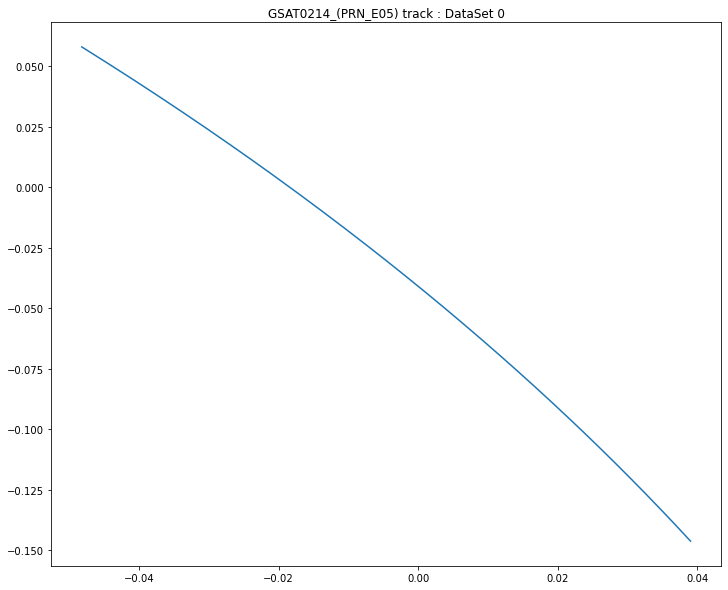

In [29]:
Theories[0].trackPlot(cut=[500,700],sats=['GSAT0214_(PRN_E05)'])

In [25]:
Theories[0].setParameters({'A_GPS_BIIRM-6_(PRN_07)':0})

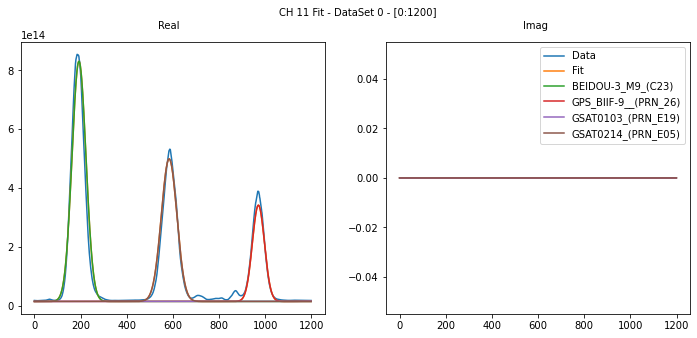

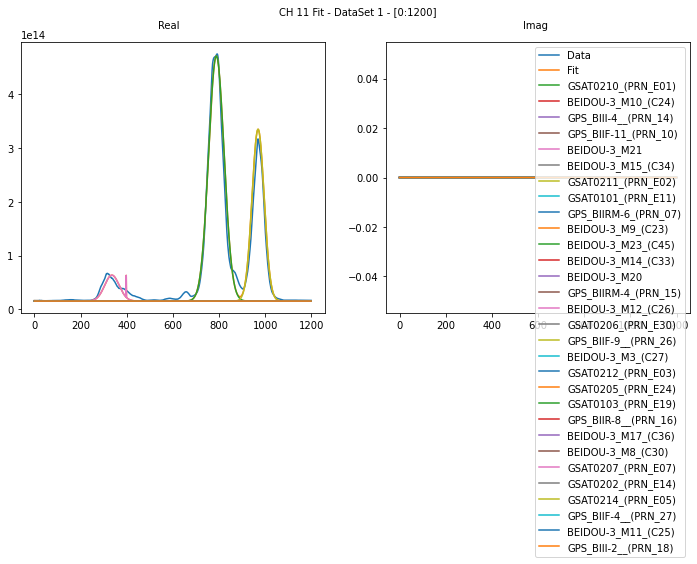

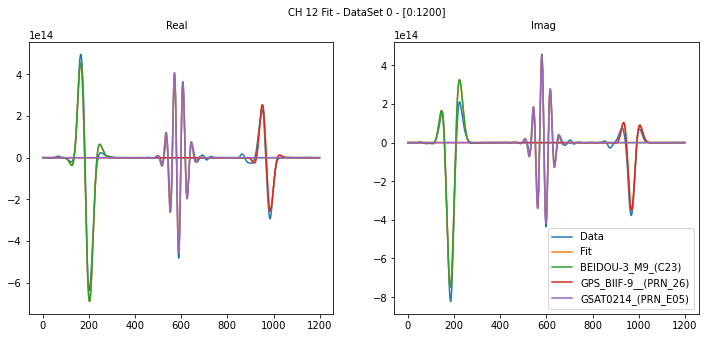

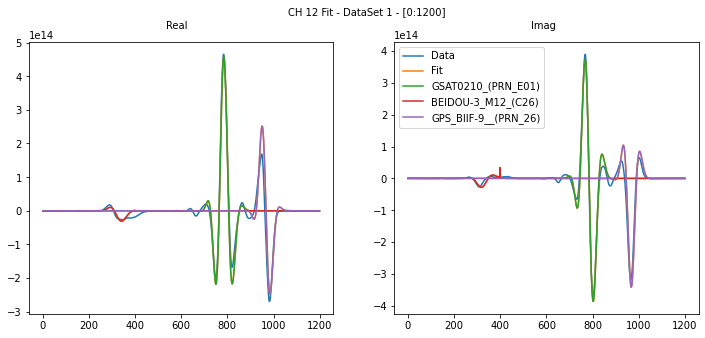

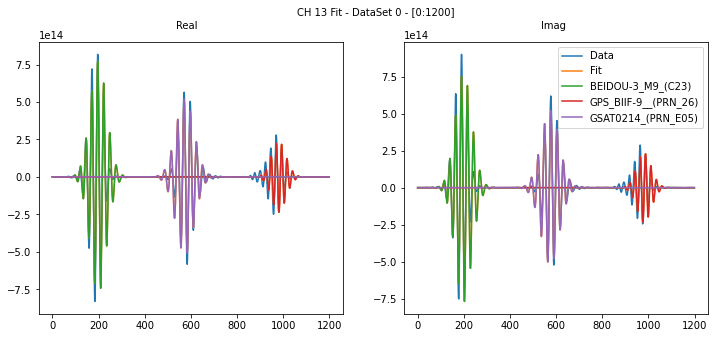

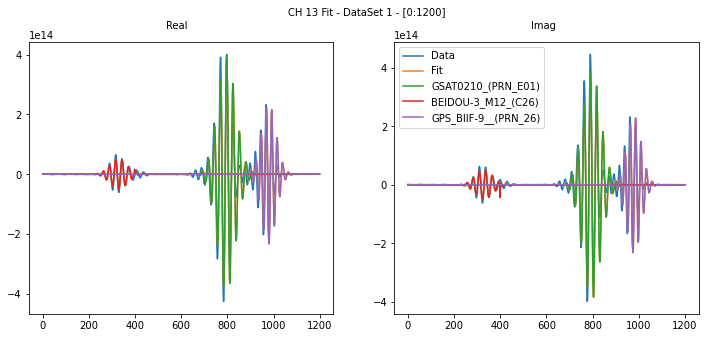

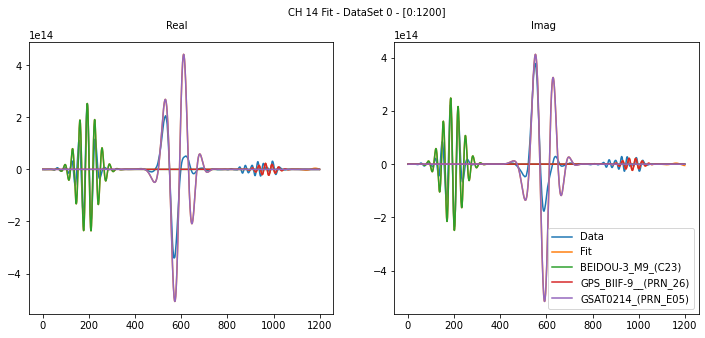

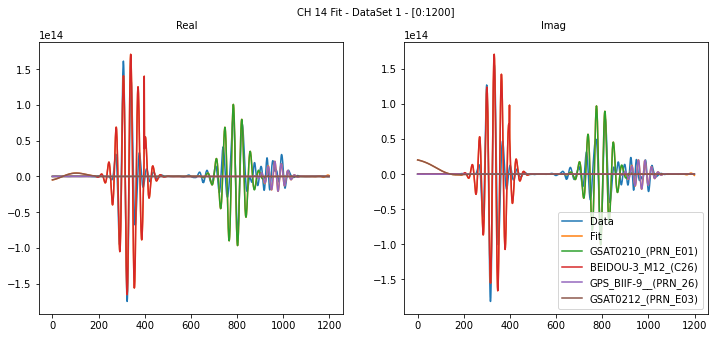

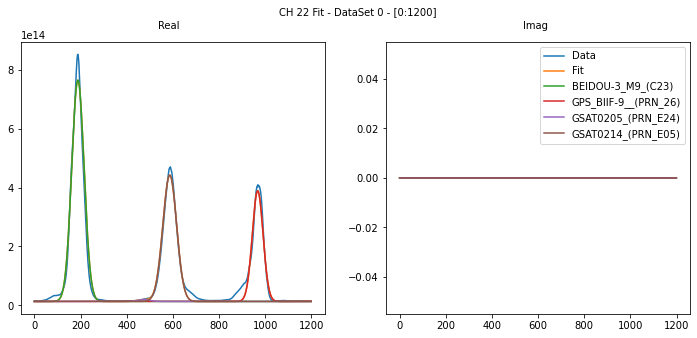

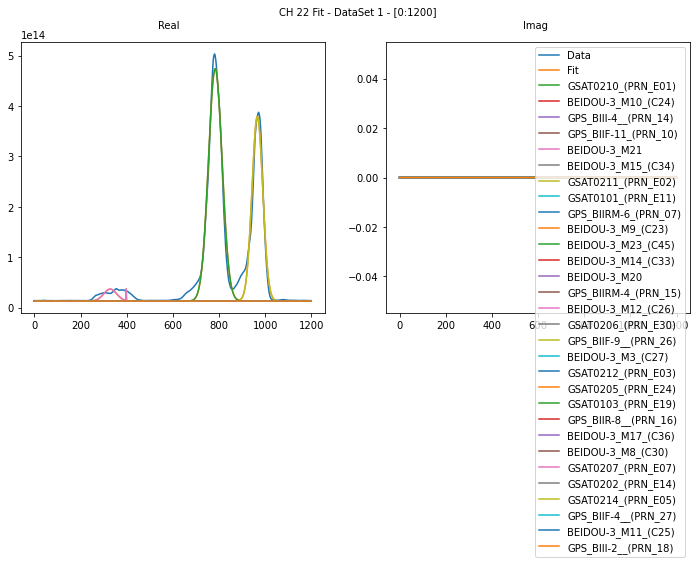

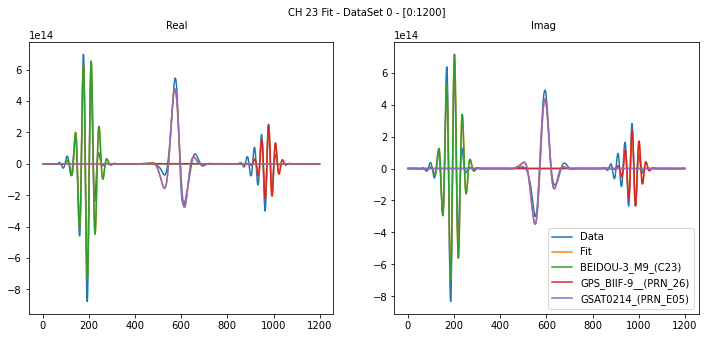

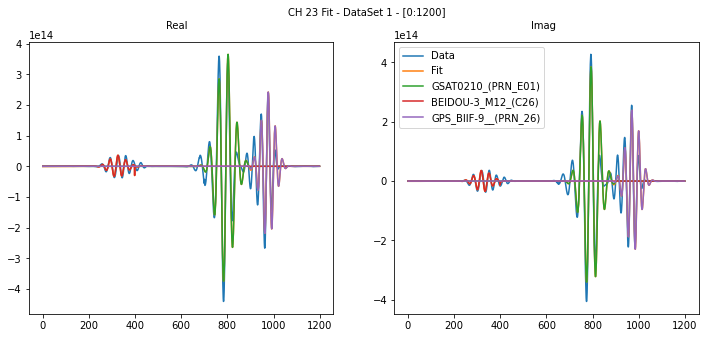

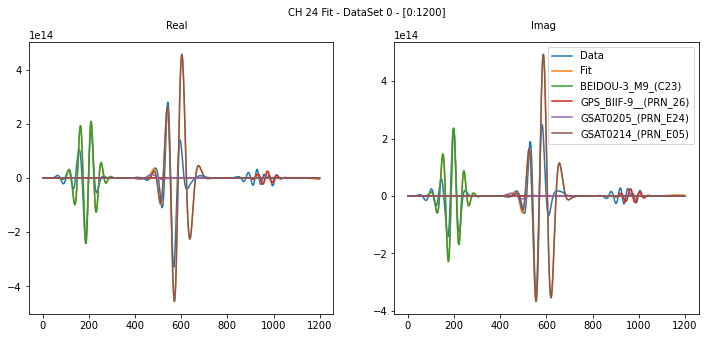

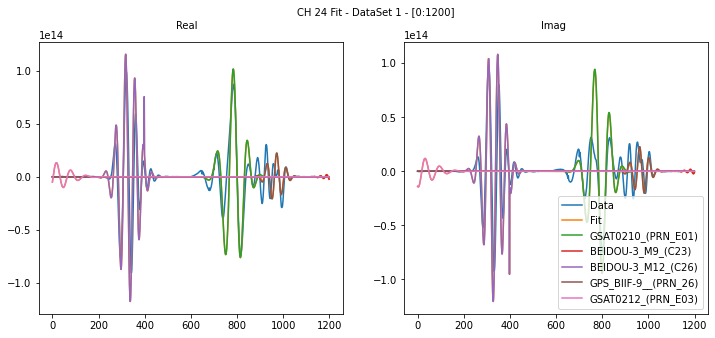

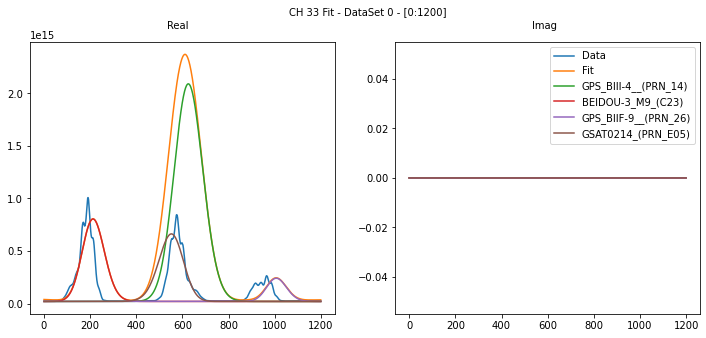

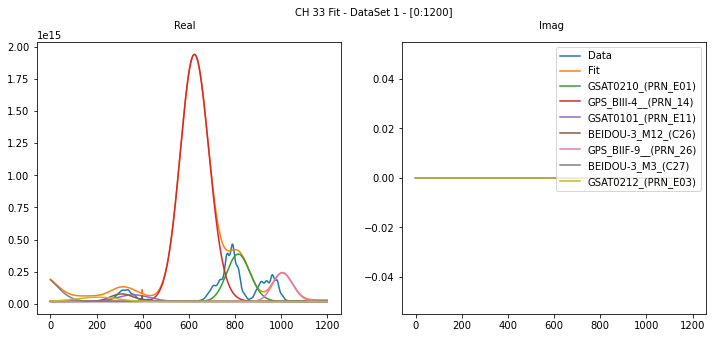

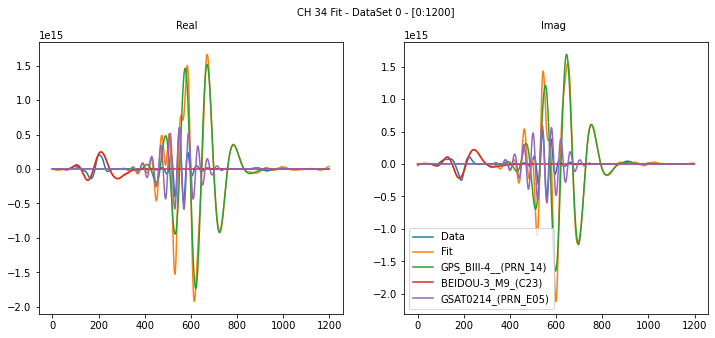

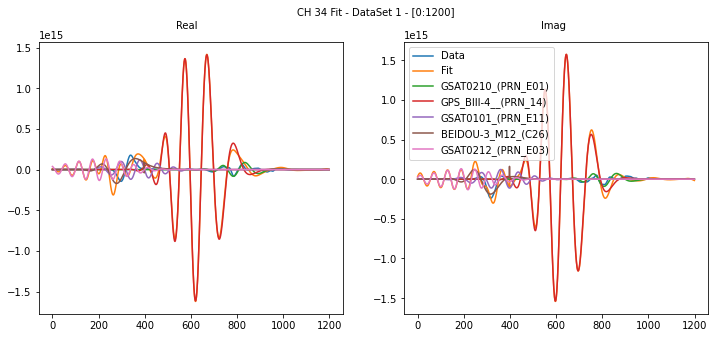

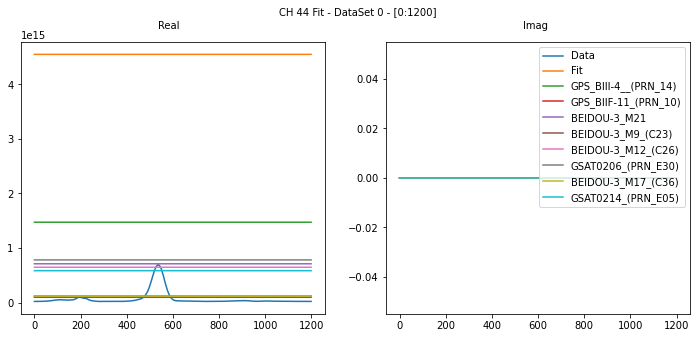

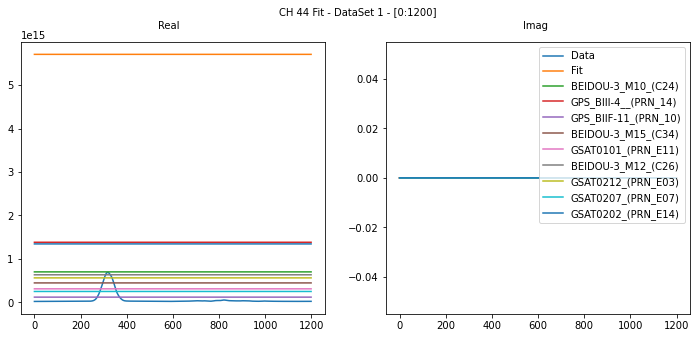

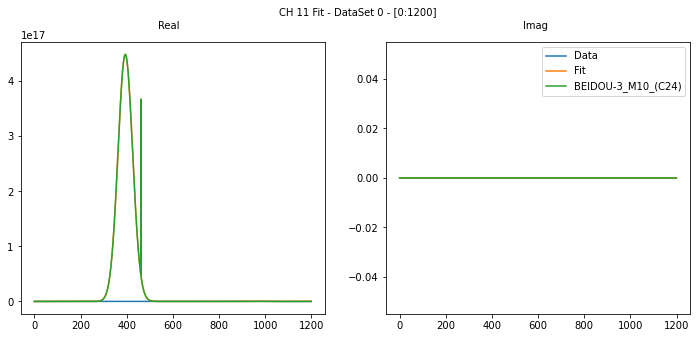

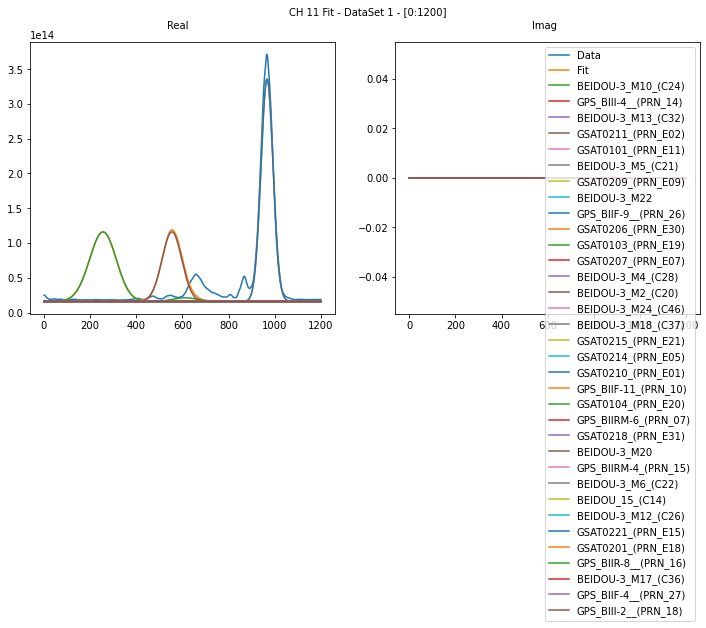

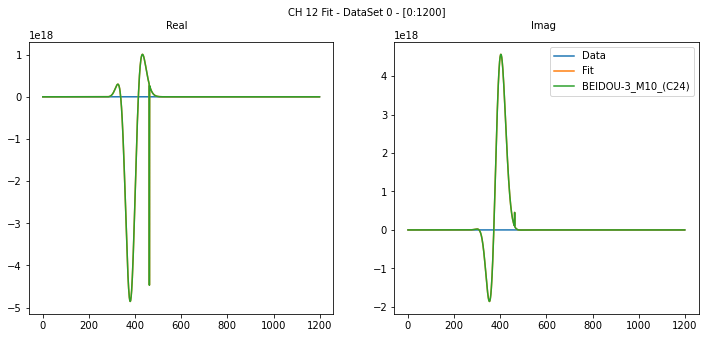

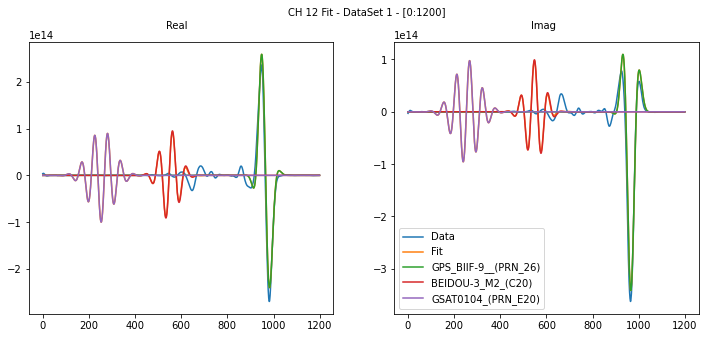

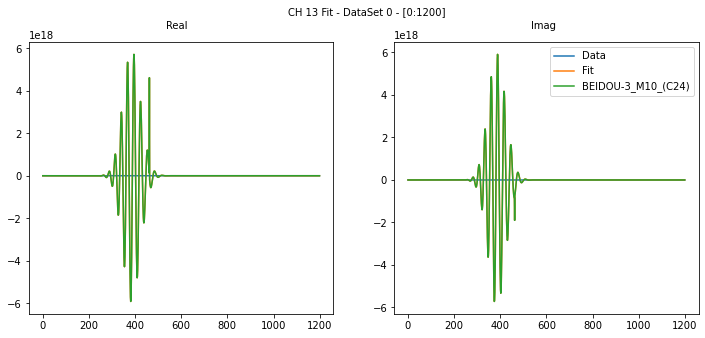

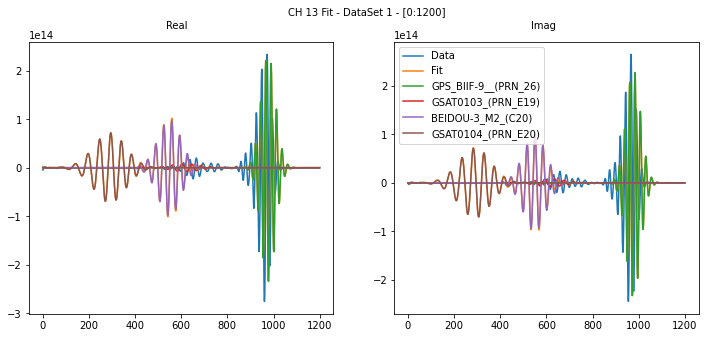

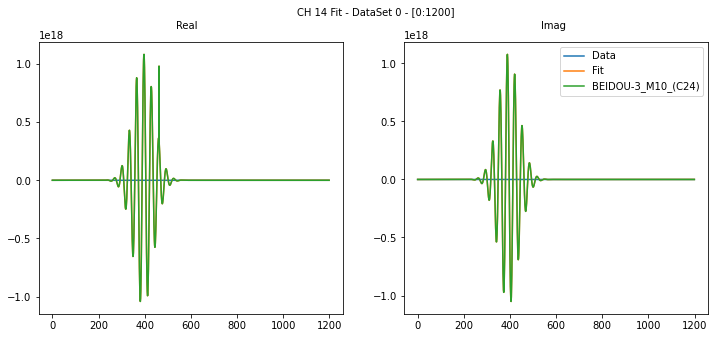

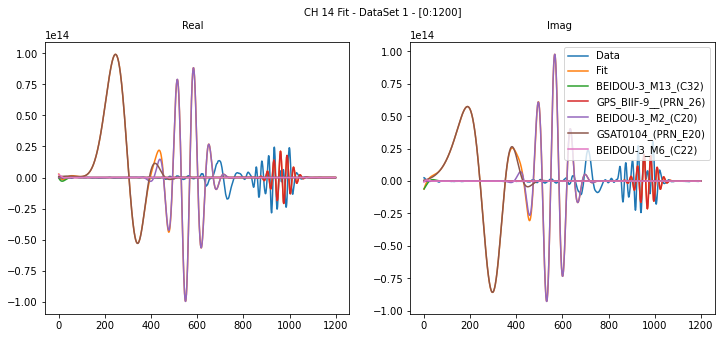

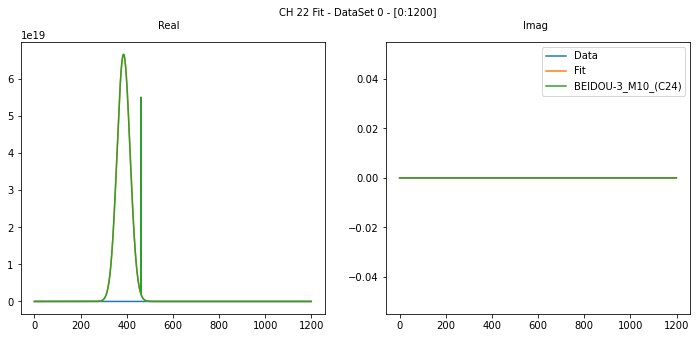

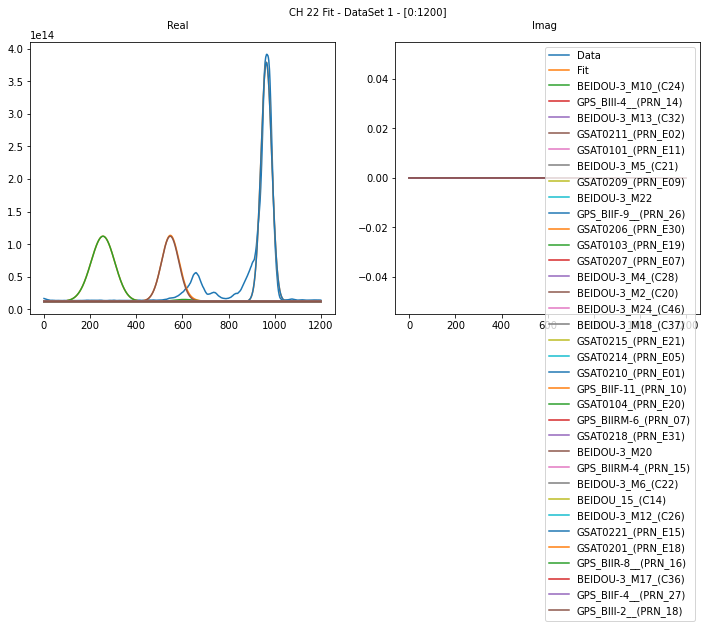

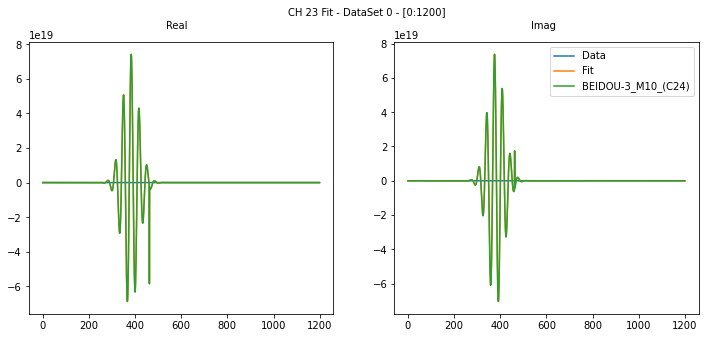

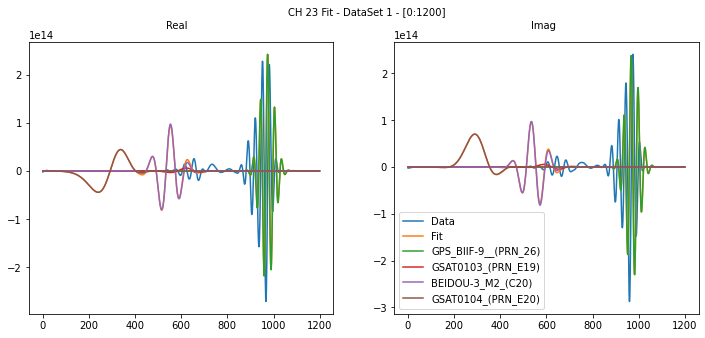

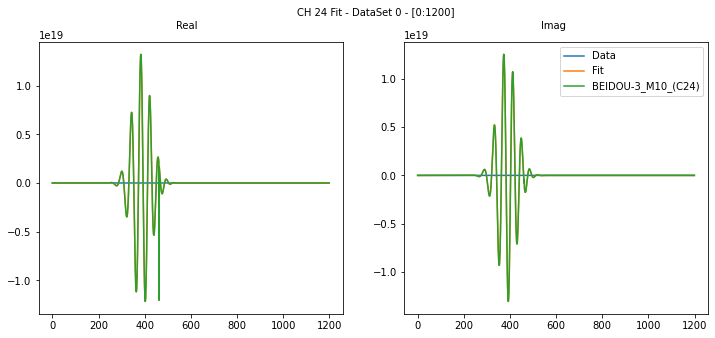

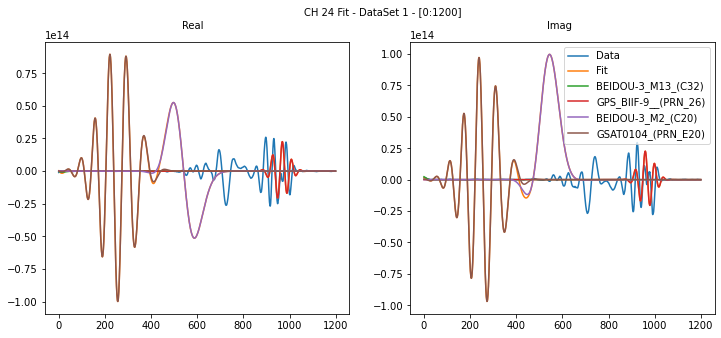

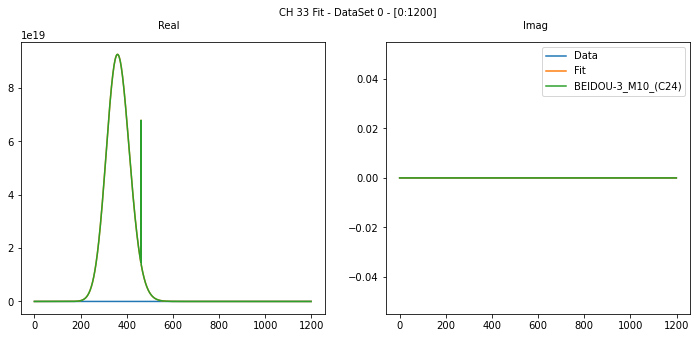

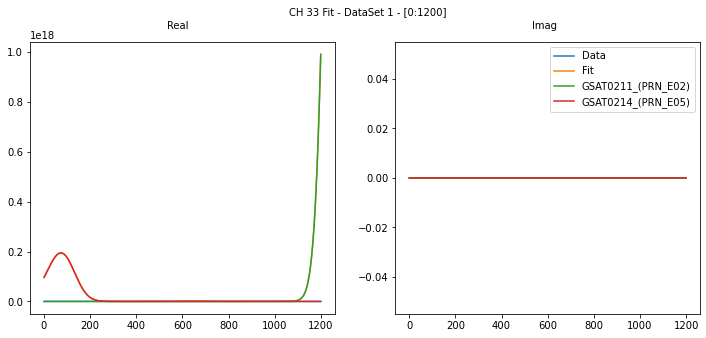

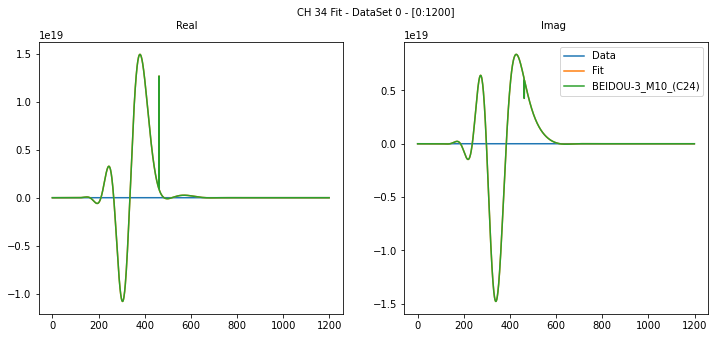

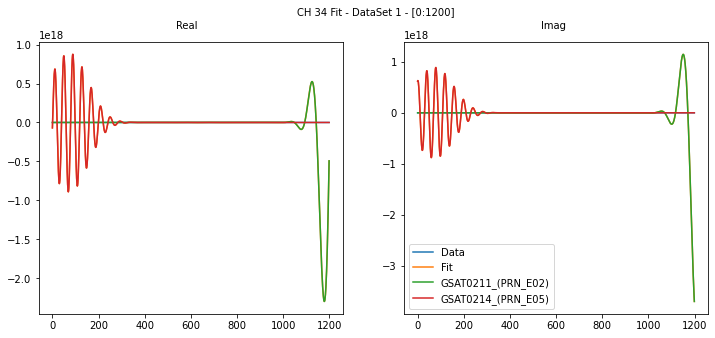

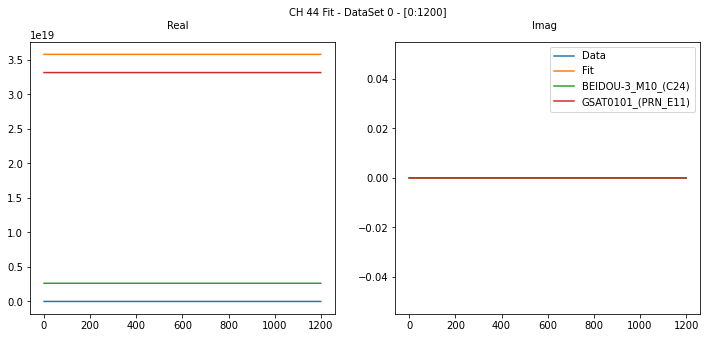

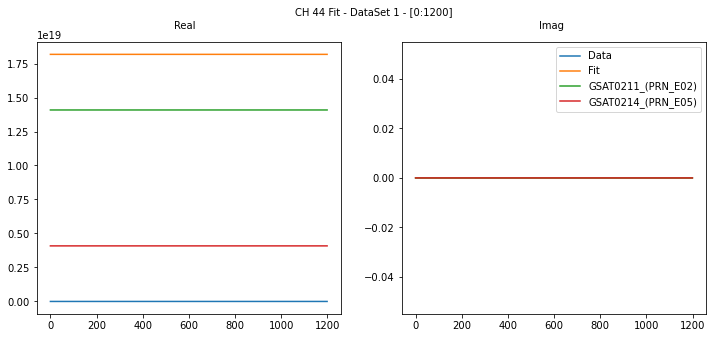

In [31]:
cut = [0,1200]
channels = [11,12,13,14,22,23,24,33,34,44]
mode = 'all'

for T in Theories:
    T.showFit(channels = channels, cut=cut,mode=mode, perSat=True)

In [35]:
for T in Theories:
    print(T.readParameters())
    print()

{'A1_GSAT0101_(PRN_E11)_0': 1963489445.342886, 'A1_GSAT0101_(PRN_E11)_1': 9284.330846270424, 'A2_GSAT0101_(PRN_E11)_0': 160108715.43861642, 'A2_GSAT0101_(PRN_E11)_1': 4151380.436953615, 'A3_GSAT0101_(PRN_E11)_0': 2339679691.892709, 'A3_GSAT0101_(PRN_E11)_1': 7183508.980297707, 'A4_GSAT0101_(PRN_E11)_0': 5760222016.191277, 'A4_GSAT0101_(PRN_E11)_1': 17060477.778803032, 'A5_GSAT0101_(PRN_E11)_0': 1336200181.392933, 'A5_GSAT0101_(PRN_E11)_1': 7229290.386841518, 'A6_GSAT0101_(PRN_E11)_0': 12540764549.17202, 'A6_GSAT0101_(PRN_E11)_1': 747480.2214881283, 'A7_GSAT0101_(PRN_E11)_0': 523656070.9549019, 'A7_GSAT0101_(PRN_E11)_1': 1561910.812368567, 'A8_GSAT0101_(PRN_E11)_0': 3919720942.362178, 'A8_GSAT0101_(PRN_E11)_1': 10791399.880978467, 'GSAT0101_(PRN_E11)_track_offset_x': 0.0, 'GSAT0101_(PRN_E11)_track_offset_y': 0.0, 'GSAT0101_(PRN_E11)_time_offset': 0, 'A1_GPS_BIII-2__(PRN_18)_0': 2426773.439461068, 'A1_GPS_BIII-2__(PRN_18)_1': 3558702.3039718224, 'A2_GPS_BIII-2__(PRN_18)_0': 1525437.15978

In [22]:
Theories[0].sigSats(8200)

{'GPS_BIIF-11_(PRN_10)'}

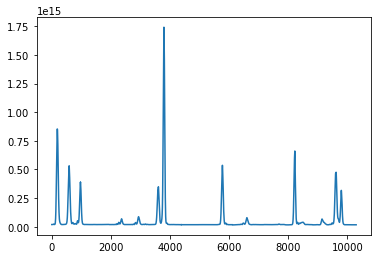

In [25]:
plt.plot(Theories[0].)

In [4]:
P = [
    {'D2_pos_x': 4.496720655923967, 'D2_pos_y': -0.6287600000433483, 'D2_phi': -0.2162769382554462, 'D3_pos_x': 0.3001220480458651, 'D3_pos_y': -5.027992542650962, 'D3_phi': 2.4221178826730054, 'D4_pos_x': -4.205341249150452, 'D4_pos_y': -0.8634242563413563, 'D4_phi': -0.360279571400098, 'D6_pos_x': 4.302920183195884, 'D6_pos_y': -0.30173473558525316, 'D6_phi': 2.7941999397976307, 'D7_pos_x': -0.11910451531087028, 'D7_pos_y': -4.367339677477533, 'D7_phi': -1.749506910188624, 'D8_pos_x': -5.115882137283665, 'D8_pos_y': -1.1103425854390399, 'D8_phi': 2.8637630024124805},
    {'D2_pos_x': 4.51328290094902, 'D2_pos_y': -0.5772916798757681, 'D2_phi': -0.24910016285190198, 'D3_pos_x': 0.5833898560167713, 'D3_pos_y': -4.860230781105983, 'D3_phi': 1.5576656715641568, 'D4_pos_x': -4.23678614745232, 'D4_pos_y': -0.5731806341881936, 'D4_phi': -1.1639513542163715, 'D6_pos_x': 4.396745500025717, 'D6_pos_y': -0.3400077323838728, 'D6_phi': 2.8336315912597936, 'D7_pos_x': -0.11996185184280196, 'D7_pos_y': -4.871861384745773, 'D7_phi': -1.465384870455939, 'D8_pos_x': -4.939572093306822, 'D8_pos_y': -0.5789959542041317, 'D8_phi': 2.9359492846132014},
    {'D2_pos_x': 4.541247000489112, 'D2_pos_y': -0.6021746922831518, 'D2_phi': -0.2496430542027421, 'D3_pos_x': 0.36059124486447086, 'D3_pos_y': -4.972908864726141, 'D3_phi': 0.6634949955203578, 'D4_pos_x': -4.548338836913454, 'D4_pos_y': -0.7900775391808744, 'D4_phi': -2.0566846469509974, 'D6_pos_x': 4.355663985415377, 'D6_pos_y': -0.387188952024975, 'D6_phi': 2.844265119068721, 'D7_pos_x': -0.005896882194541871, 'D7_pos_y': -4.435688122908201, 'D7_phi': -3.9595184724167214, 'D8_pos_x': -5.066543684393208, 'D8_pos_y': -0.9000312093224433, 'D8_phi': 0.4544019678199632},
]

P = np.array([list(p.values()) for p in P])
avg = P.sum(axis=0)/len(P)
sdv = np.sqrt(((P-avg)**2).sum(axis=0)/len(P))
print('Average:')
print(avg)
print('Standard Deviation:')
print(sdv)

Average:
[ 4.51708352 -0.60274212 -0.23834005  0.41470105 -4.95371073  1.54775952
 -4.33015541 -0.74222748 -1.19363852  4.35177656 -0.34297714  2.82403222
 -0.08165442 -4.5582964  -2.39147008 -5.04066597 -0.86312325  2.08470475]
Standard Deviation:
[0.01837539 0.02101568 0.01560255 0.12180877 0.06982086 0.71798896
 0.15481215 0.1232276  0.69287254 0.03840253 0.03494967 0.02153666
 0.05356981 0.22347279 1.11482828 0.07426776 0.21848563 1.15317477]
